In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
sp500 = pd.read_csv('sp500.csv')
sp500['Date'] = pd.to_datetime(sp500['Date'])
sp500.set_index('Date', inplace=True)
sp500 = sp500[(sp500.index.year > 1979)]
sp500['sp500_dr'] = sp500['^GSPC'].pct_change()

{{< pagebreak >}}
# Project Scope
### Do stock correlations within the S&P 500 index go to one during crises?

1. Identifying Crises: A crisis is defined as a 20% decline in the S&P500 index from its peak, and ending when the index recovers 20% from its lowest point during the drawdown.
2. Analyzing Correlations: 
    + Data: Correlations calculated for all pairs of S&P 500 stocks (plus the index).
    + Frequencies: Monthly, quarterly, and rolling 20-day windows.
    + Analysis: Includes summary statistics and a total count of unique correlations (Number of unique correlations: 
    
        (n! / (2! * (n-2)!))

3. Calculating Betas: To measure the volatility of individual stocks relative to the S&P 500 index and help in understanding their behavior during financial crises.      

## Our predictions before the result
1.	We expect the average correlation to approach one during crises, as market participants tend to panic and shift their funds to safer assets in such times. Consequently, stocks tend to fall with a similar magnitude across the market.
2.	We expect most betas to cluster around 1, indicating similar volatility to the broader market. However, some betas may deviate significantly from 1 due to the unique circumstances and impacts surrounding each crisis.
3.	We predict higher correlations during the initial phases of financial crises, as market-wide factors and investor panic tend to affect stock movements.

{{< pagebreak >}}
 

# Crisis Periods

In [3]:
def find_crisis_periods_with_peaks_troughs(df, column_name):
    rolling_max = df[column_name].cummax()
    crisis_periods = []
    peaks_troughs = []
    in_crisis = False
    crisis_start = None
    trough = None
    last_peak = None

    for date, value in df[column_name].items():
        if not in_crisis:
            if value >= rolling_max.loc[date]:
                last_peak = (date)
            
            if value <= rolling_max.loc[date] * 0.8:
                in_crisis = True
                crisis_start = date
                trough = (date,value)
        else:
            if value < trough[1]:
                trough = (date, value)
            
            if value >= trough[1] * 1.2:
                in_crisis = False
                crisis_end = date
                crisis_periods.append((crisis_start, crisis_end))
                peaks_troughs.append((last_peak, trough[0]))
                rolling_max = df.loc[date:][column_name].cummax()

    return crisis_periods, peaks_troughs

crisis_periods, peaks_troughs = find_crisis_periods_with_peaks_troughs(sp500, '^GSPC')

crises = pd.DataFrame(crisis_periods, columns = ['Start date', 'End date'])
peak_trough = pd.DataFrame(peaks_troughs, columns = ['Peak', 'Trough'])

crises

Start date   End date
0 1982-02-22 1982-09-14
1 1987-10-19 1988-03-08
2 2001-03-12 2001-12-05
3 2002-07-10 2002-08-22
4 2008-07-09 2008-12-08
5 2009-02-23 2009-03-23
6 2020-03-12 2020-04-08
7 2022-06-13 2023-06-08

## Here is a graph showcasing crises periods during our entire observation

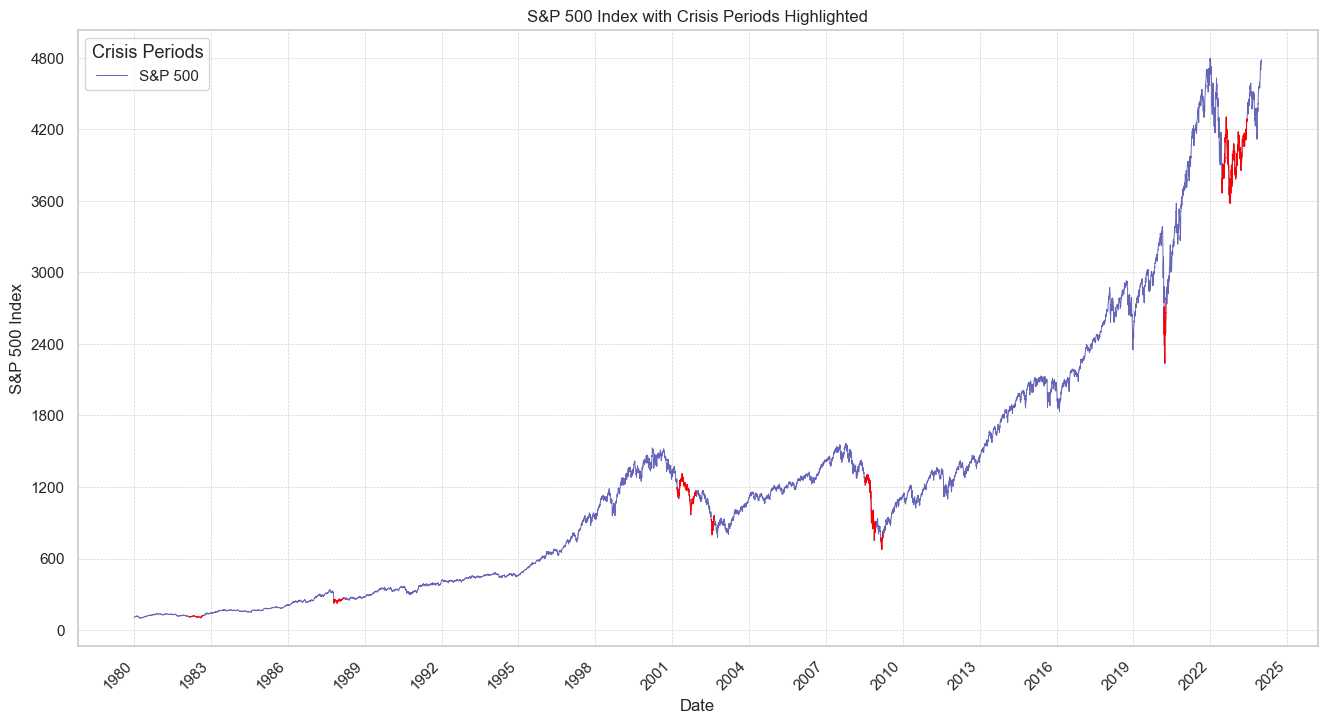

In [4]:
crisis_mask = pd.Series(False, index=sp500.index)
for start, end in crisis_periods:
    crisis_mask |= (sp500.index >= start) & (sp500.index <= end)
    
sns.set(style='whitegrid')
plt.figure(figsize=(16, 8))
plt.plot(sp500.index, sp500['^GSPC'], color='darkblue', label='S&P 500', alpha=0.6, linewidth=0.7)

for start, end in crisis_periods:
    crisis_data = sp500.loc[start:end]
    plt.plot(crisis_data.index, crisis_data['^GSPC'], color='red', linewidth=0.7)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=3))
ax.xaxis.set_minor_locator(mdates.YearLocator(3)) 
ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=10))  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45, ha="right")
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')
plt.xlabel('Date')
plt.ylabel('S&P 500 Index')
plt.title('S&P 500 Index with Crisis Periods Highlighted')
plt.legend(loc='upper left', title='Crisis Periods', title_fontsize='13', fontsize='11')
plt.show()

{{< pagebreak >}}
# Correlation Analysis

## Monthly & Quarterly Correlations - Mean 

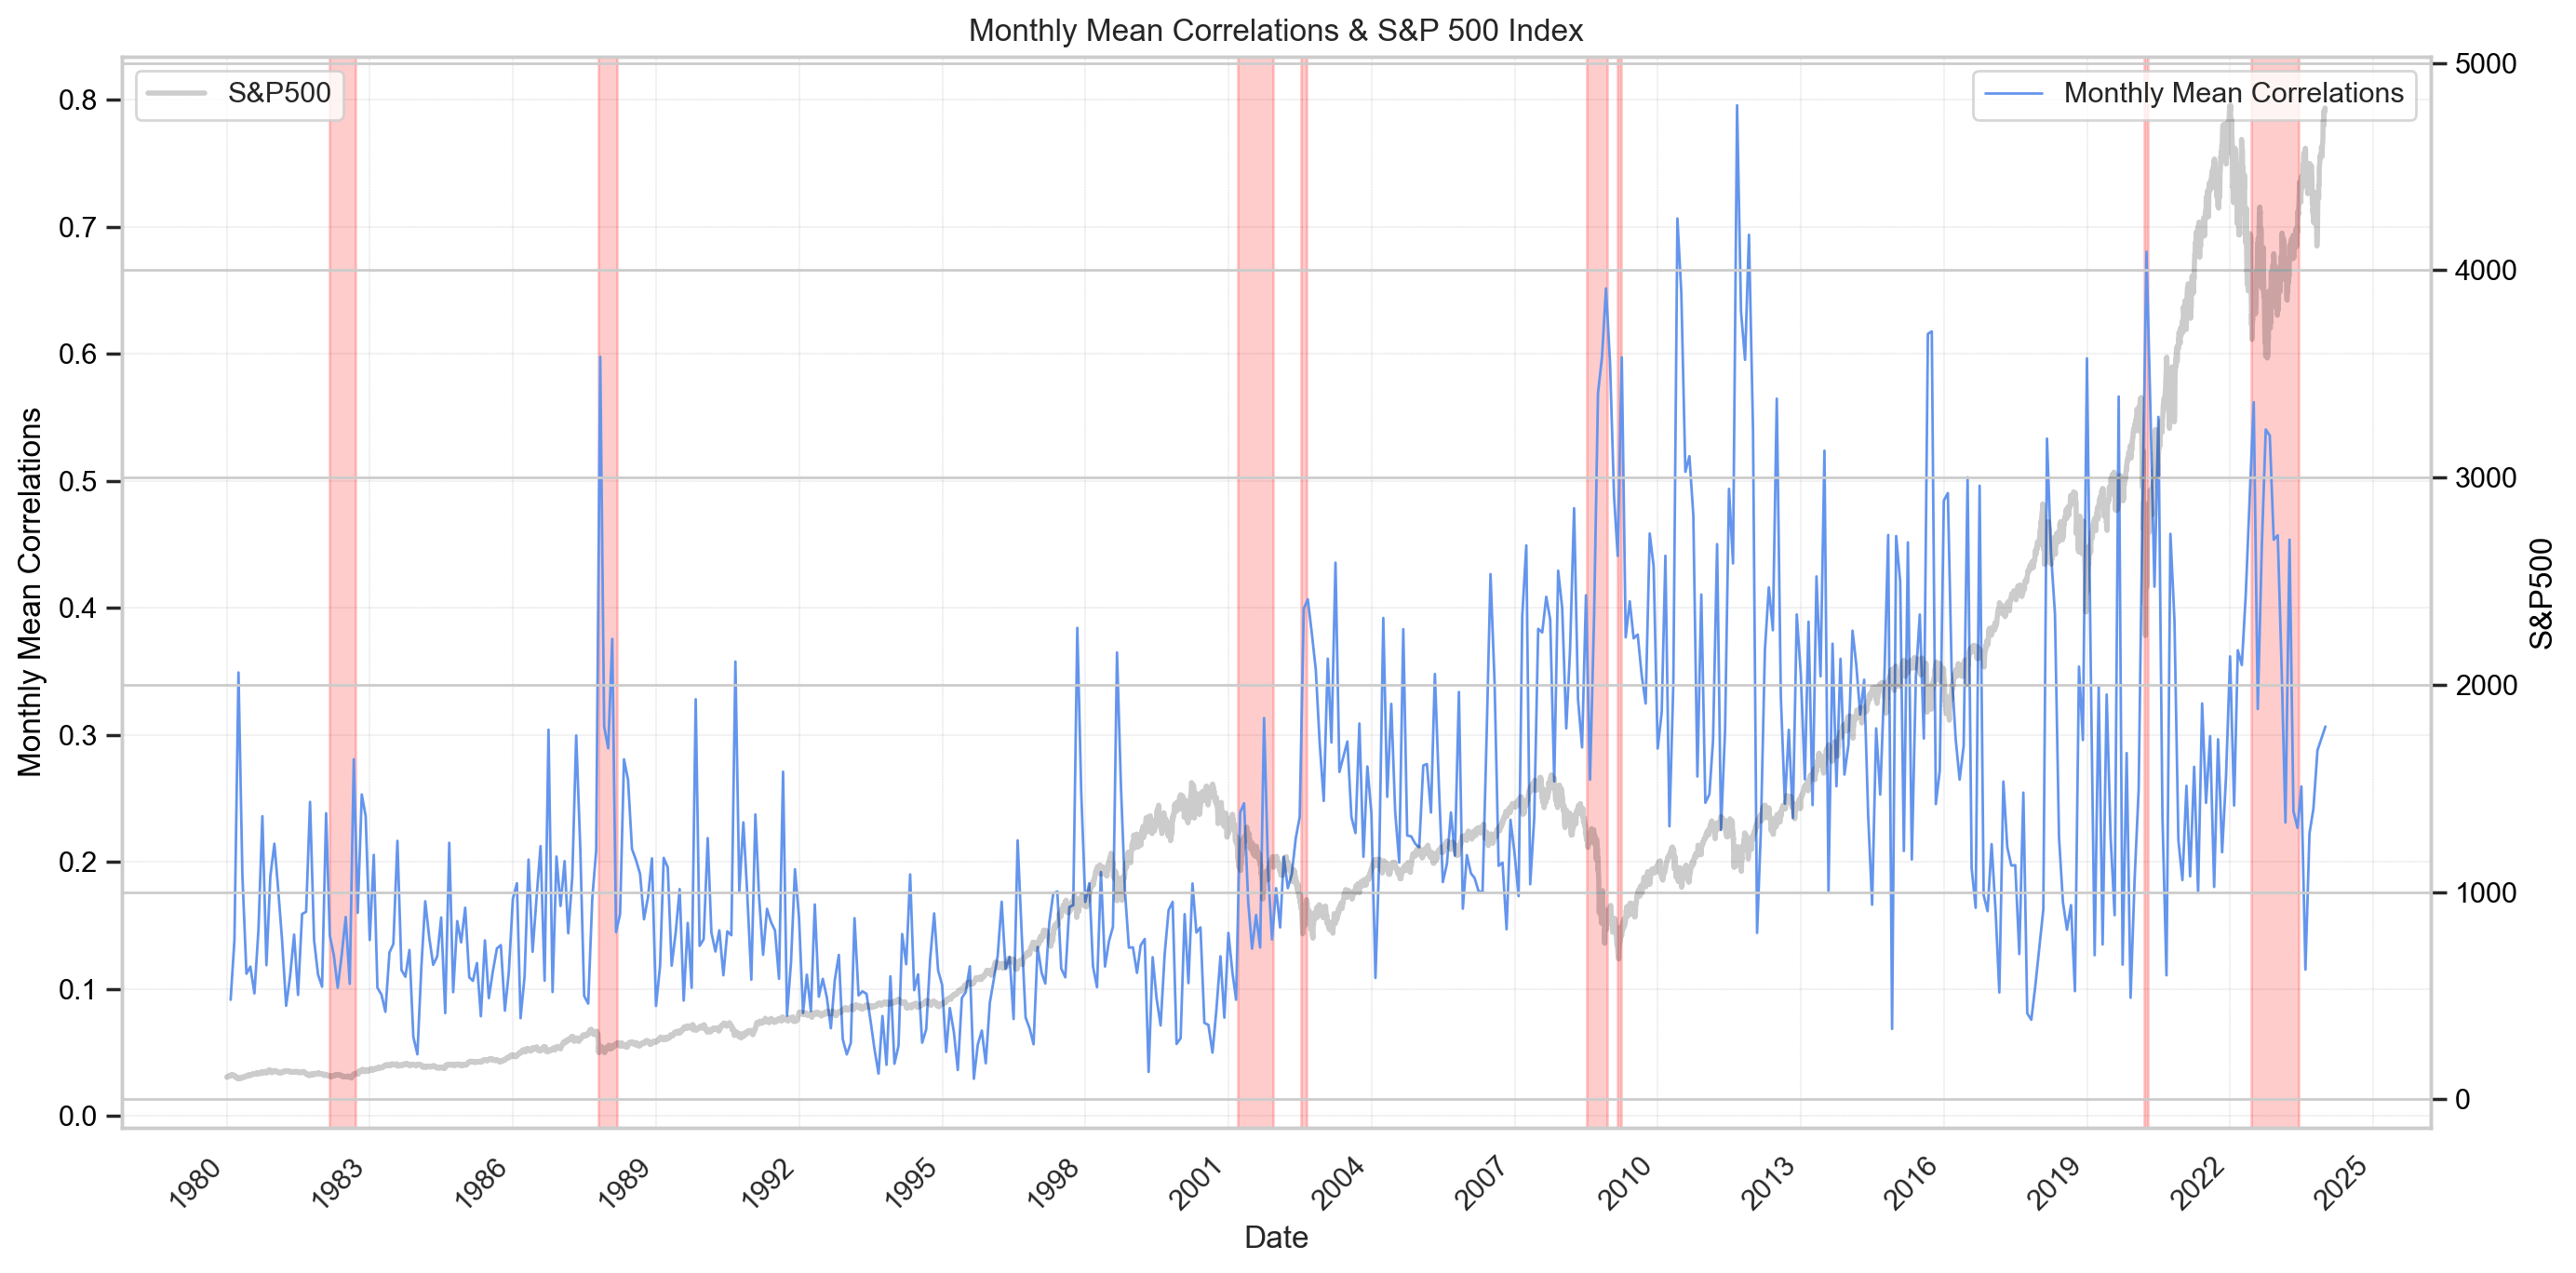

In [5]:
# MONTHLY MEAN
monthly_mean_correlations = sp500.iloc[:,:-2].groupby(pd.Grouper(freq='M')).apply(
    lambda x: x.corr().mask(np.triu(np.ones(x.corr().shape), k=0).astype(bool)).stack().mean())

fig, ax1 = plt.subplots(figsize=(14, 7), dpi = 200)

ax1.set_xlabel('Date')
ax1.set_ylabel('Monthly Mean Correlations', color='black')
ax1.plot(monthly_mean_correlations.index, monthly_mean_correlations, color='cornflowerblue', linewidth=1, label='Monthly Mean Correlations')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, which='major', linestyle='--', linewidth='0.1', color='grey')
ax1.grid(True, which='minor', linestyle=':', linewidth='0.1', color='grey')

for start, end in crisis_periods:
    ax1.axvspan(start, end, color='red', alpha=0.2)

ax2 = ax1.twinx()  
ax2.set_ylabel('S&P500', color='black')  
ax2.plot(sp500['^GSPC'].index, sp500['^GSPC'], color='black', linewidth = 2, alpha = 0.2, label='S&P500')
ax2.tick_params(axis='y', labelcolor='black')

ax1.xaxis.set_major_locator(mdates.YearLocator(3))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

ax2.legend(loc='upper left')
ax1.legend(loc='upper right')

plt.title("Monthly Mean Correlations & S&P 500 Index")
plt.tight_layout()
plt.show()

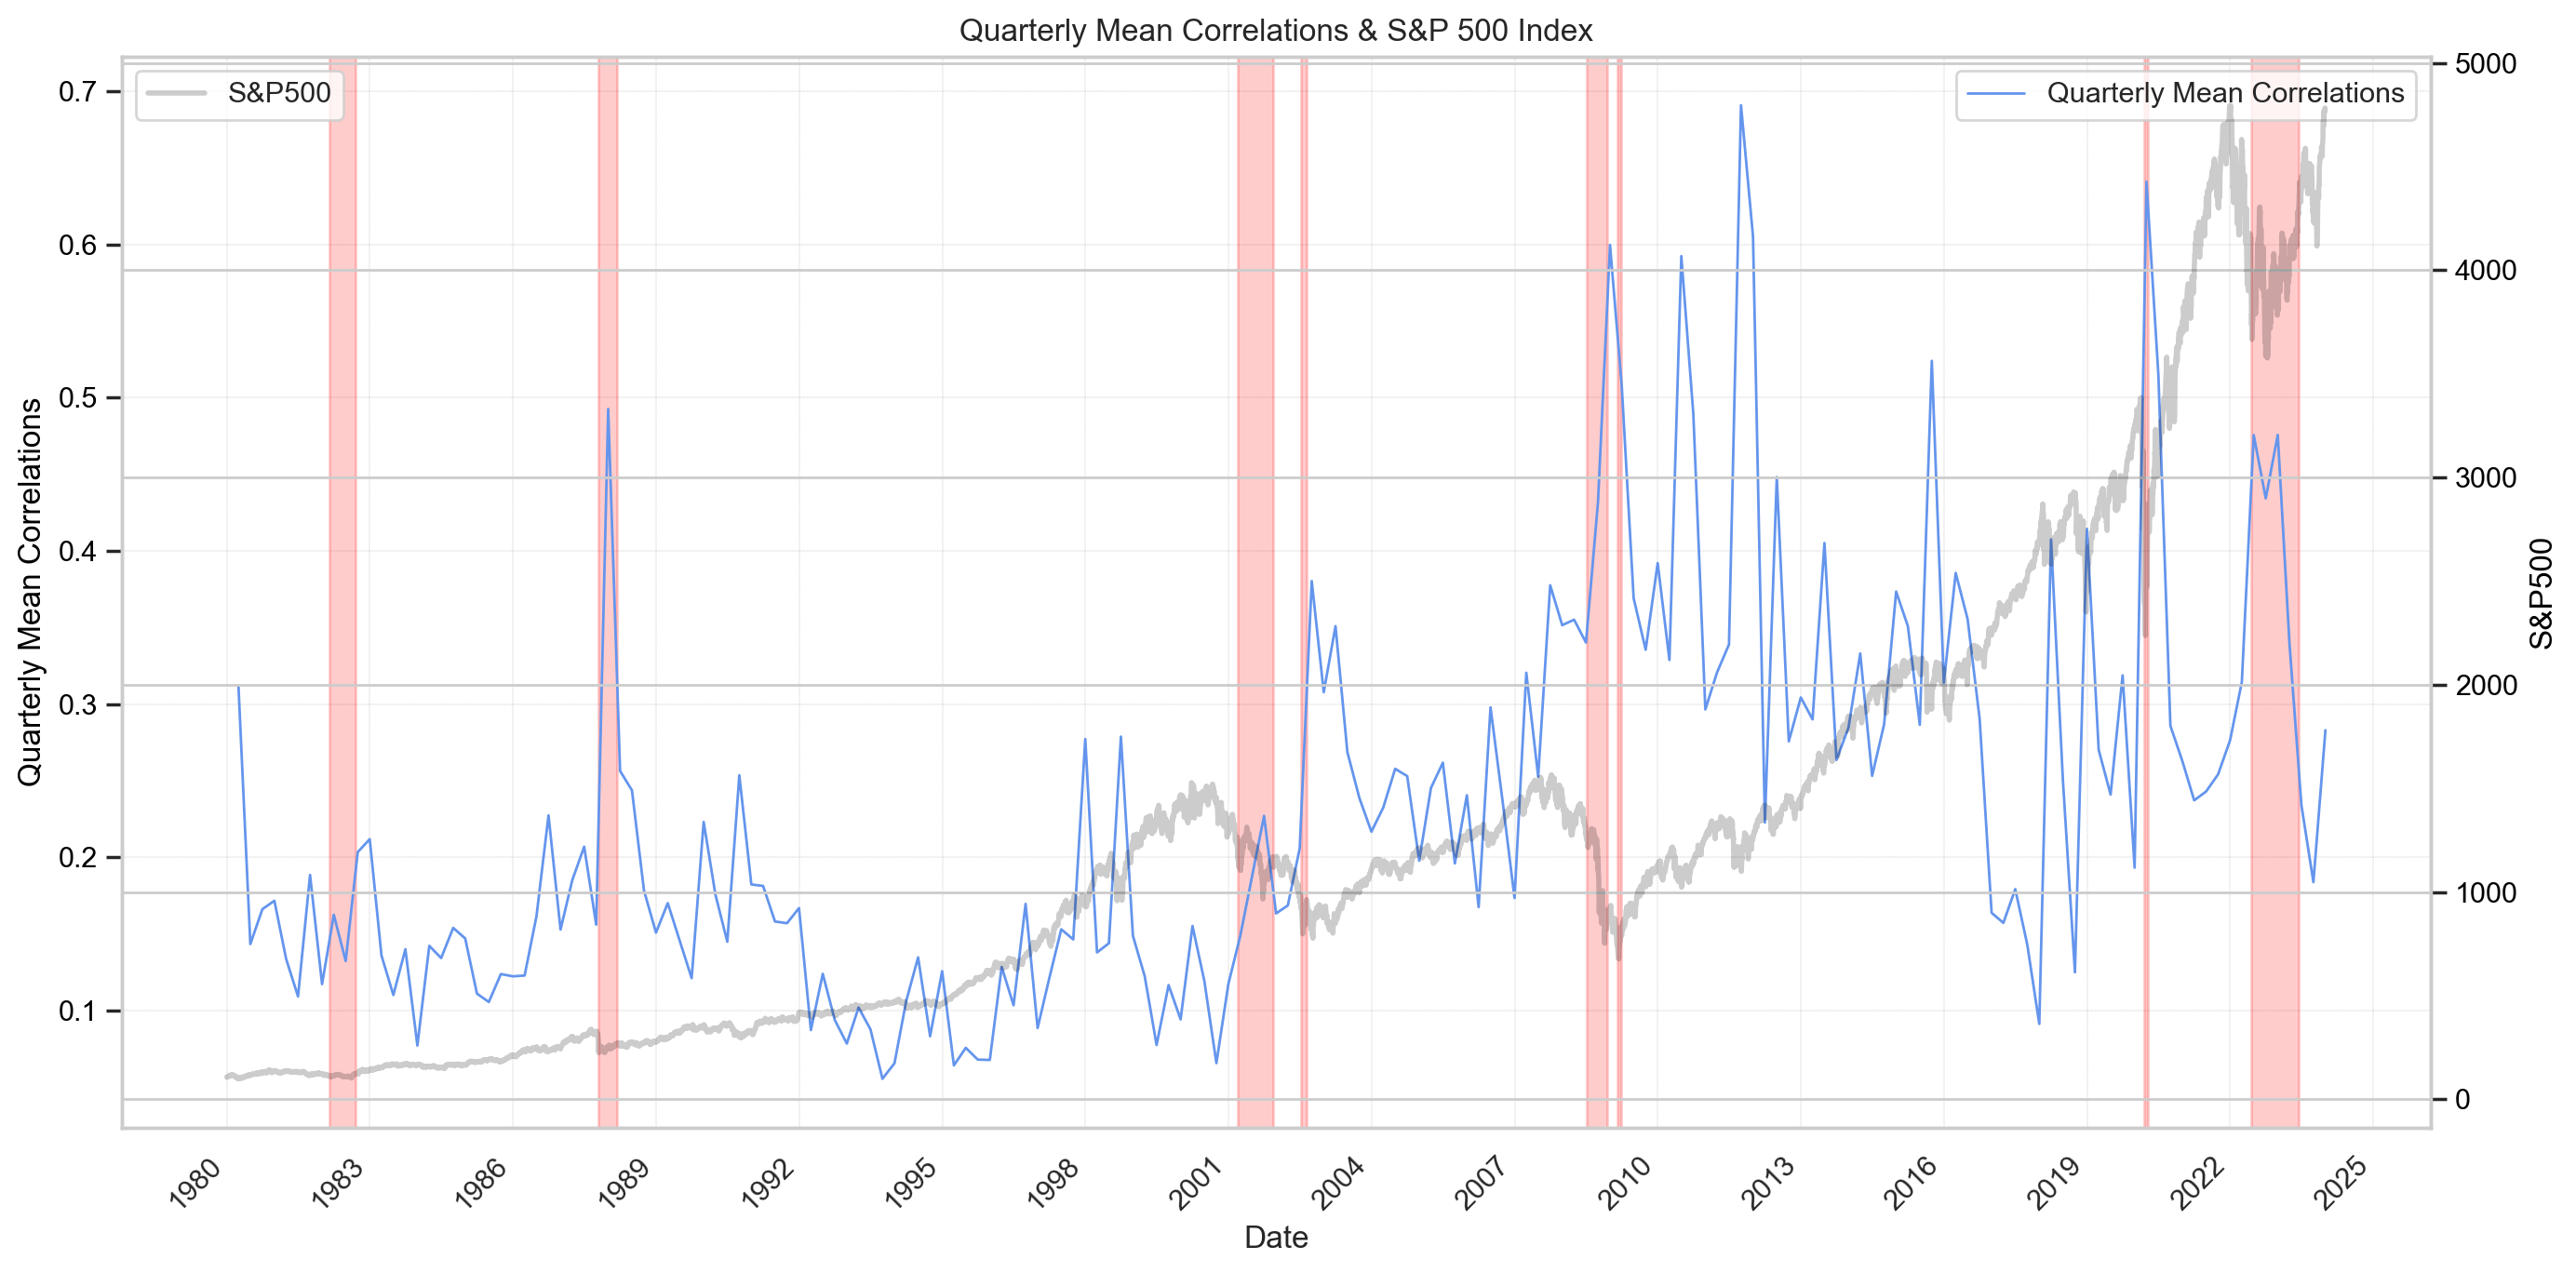

In [6]:
# QUARTERLY MEAN
quarterly_mean_correlations = sp500.iloc[:,:-2].groupby(pd.Grouper(freq='Q')).apply(
    lambda x: x.corr().mask(np.triu(np.ones(x.corr().shape), k=0).astype(bool)).stack().mean())

fig, ax1 = plt.subplots(figsize=(14, 7), dpi = 200)

# color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Quarterly Mean Correlations', color='black')
ax1.plot(quarterly_mean_correlations.index, quarterly_mean_correlations, color='cornflowerblue', linewidth=1, label = 'Quarterly Mean Correlations')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, which='major', linestyle='--', linewidth='0.1', color='grey')
ax1.grid(True, which='minor', linestyle=':', linewidth='0.1', color='grey')

for start, end in crisis_periods:
    ax1.axvspan(start, end, color='red', alpha=0.2)

ax2 = ax1.twinx()  
ax2.set_ylabel('S&P500', color='black')  
ax2.plot(sp500['^GSPC'].index, sp500['^GSPC'], color='black', linewidth = 2, alpha = 0.2, label = 'S&P500')
ax2.tick_params(axis='y', labelcolor='black')

ax1.xaxis.set_major_locator(mdates.YearLocator(3))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

ax2.legend(loc='upper left')
ax1.legend(loc='upper right')

plt.title("Quarterly Mean Correlations & S&P 500 Index")
plt.tight_layout()
plt.show()

### Mean Analysis:
1. Correlations tend to become stronger around financial crises.
2. Observations do not show an average correlation of 1 for all stocks, though they approach 1.
3. Since a number of stocks might also show negative correlations, the mean might not show the complete true picture.


{{< pagebreak >}}

## Monthly & Quarterly Correlations - Median 

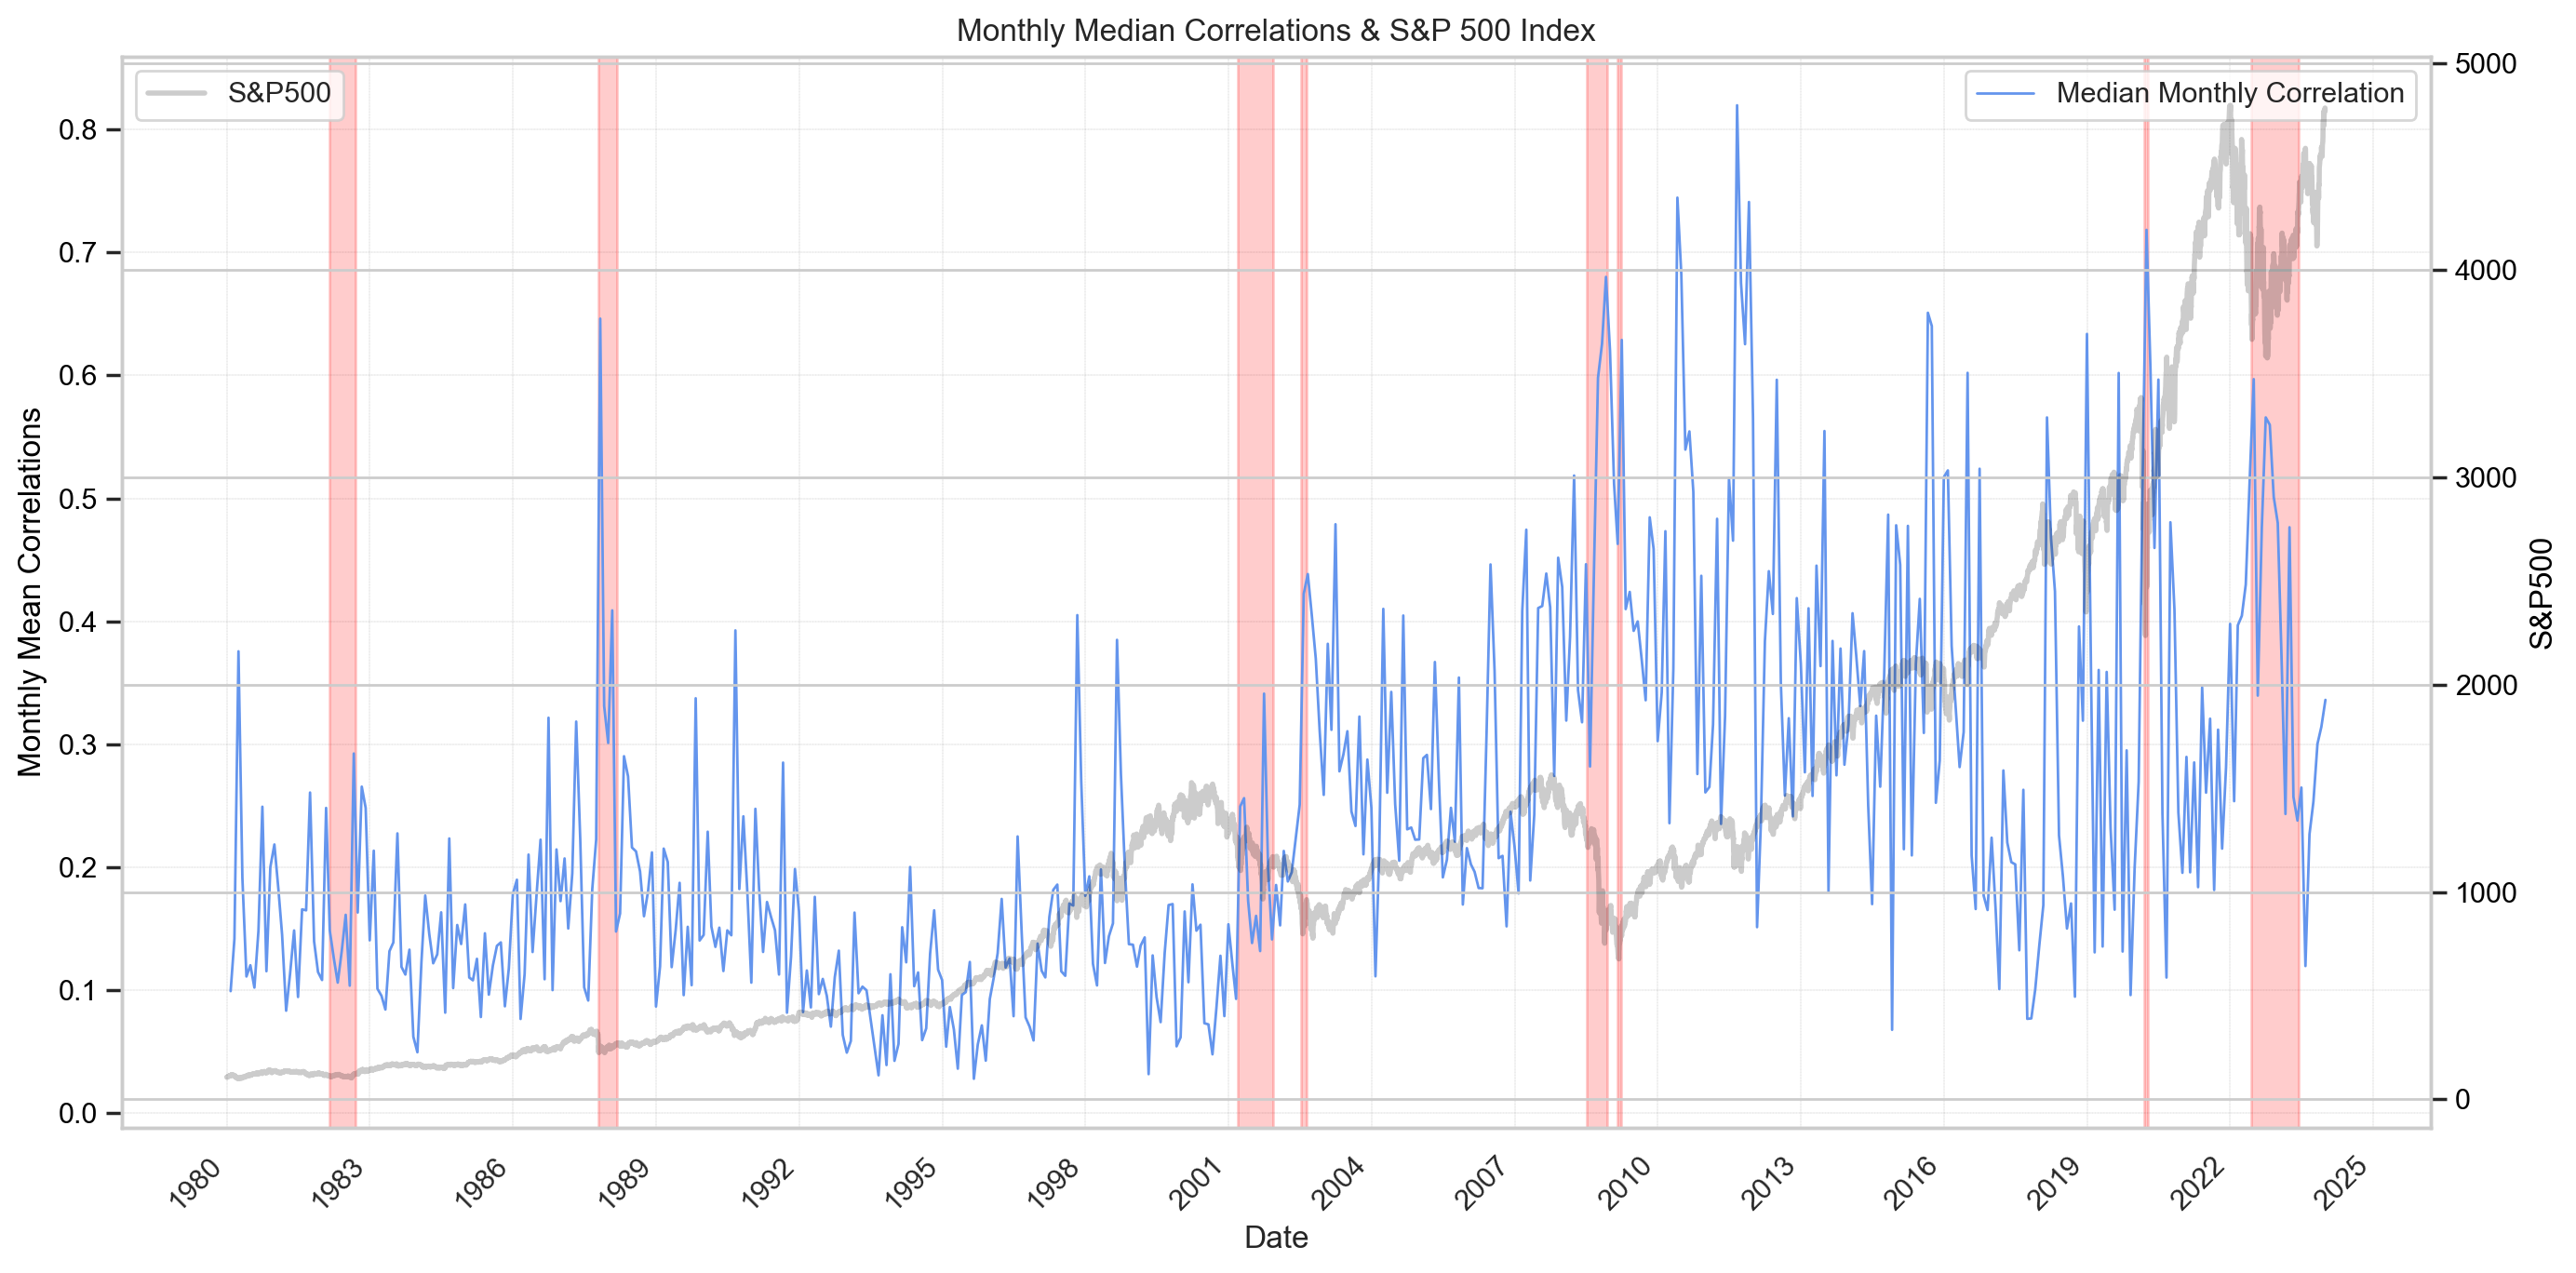

In [7]:
# MONTHLY MEDIAN
monthly_median_correlations = sp500.iloc[:,:-2].groupby(pd.Grouper(freq='M')).apply(
    lambda x: x.corr().mask(np.triu(np.ones(x.corr().shape), k=0).astype(bool)).stack().median())

fig, ax1 = plt.subplots(figsize=(14, 7), dpi = 200)

# color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Monthly Mean Correlations', color='black')
ax1.plot(monthly_median_correlations.index, monthly_median_correlations, color='cornflowerblue', linewidth=1, label = "Median Monthly Correlation")
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, which='major', linestyle='--', linewidth='0.1', color='grey')
ax1.grid(True, which='minor', linestyle=':', linewidth='0.1', color='grey')

for start, end in crisis_periods:
    ax1.axvspan(start, end, color='red', alpha=0.2)

ax2 = ax1.twinx()  
ax2.set_ylabel('S&P500', color='black')  
ax2.plot(sp500['^GSPC'].index, sp500['^GSPC'], color='black', linewidth = 2, alpha = 0.2, label = 'S&P500')
ax2.tick_params(axis='y', labelcolor='black')

ax1.xaxis.set_major_locator(mdates.YearLocator(3))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

ax2.legend(loc='upper left')
ax1.legend(loc='upper right')

plt.legend()
plt.title("Monthly Median Correlations & S&P 500 Index")
plt.tight_layout()
plt.show()

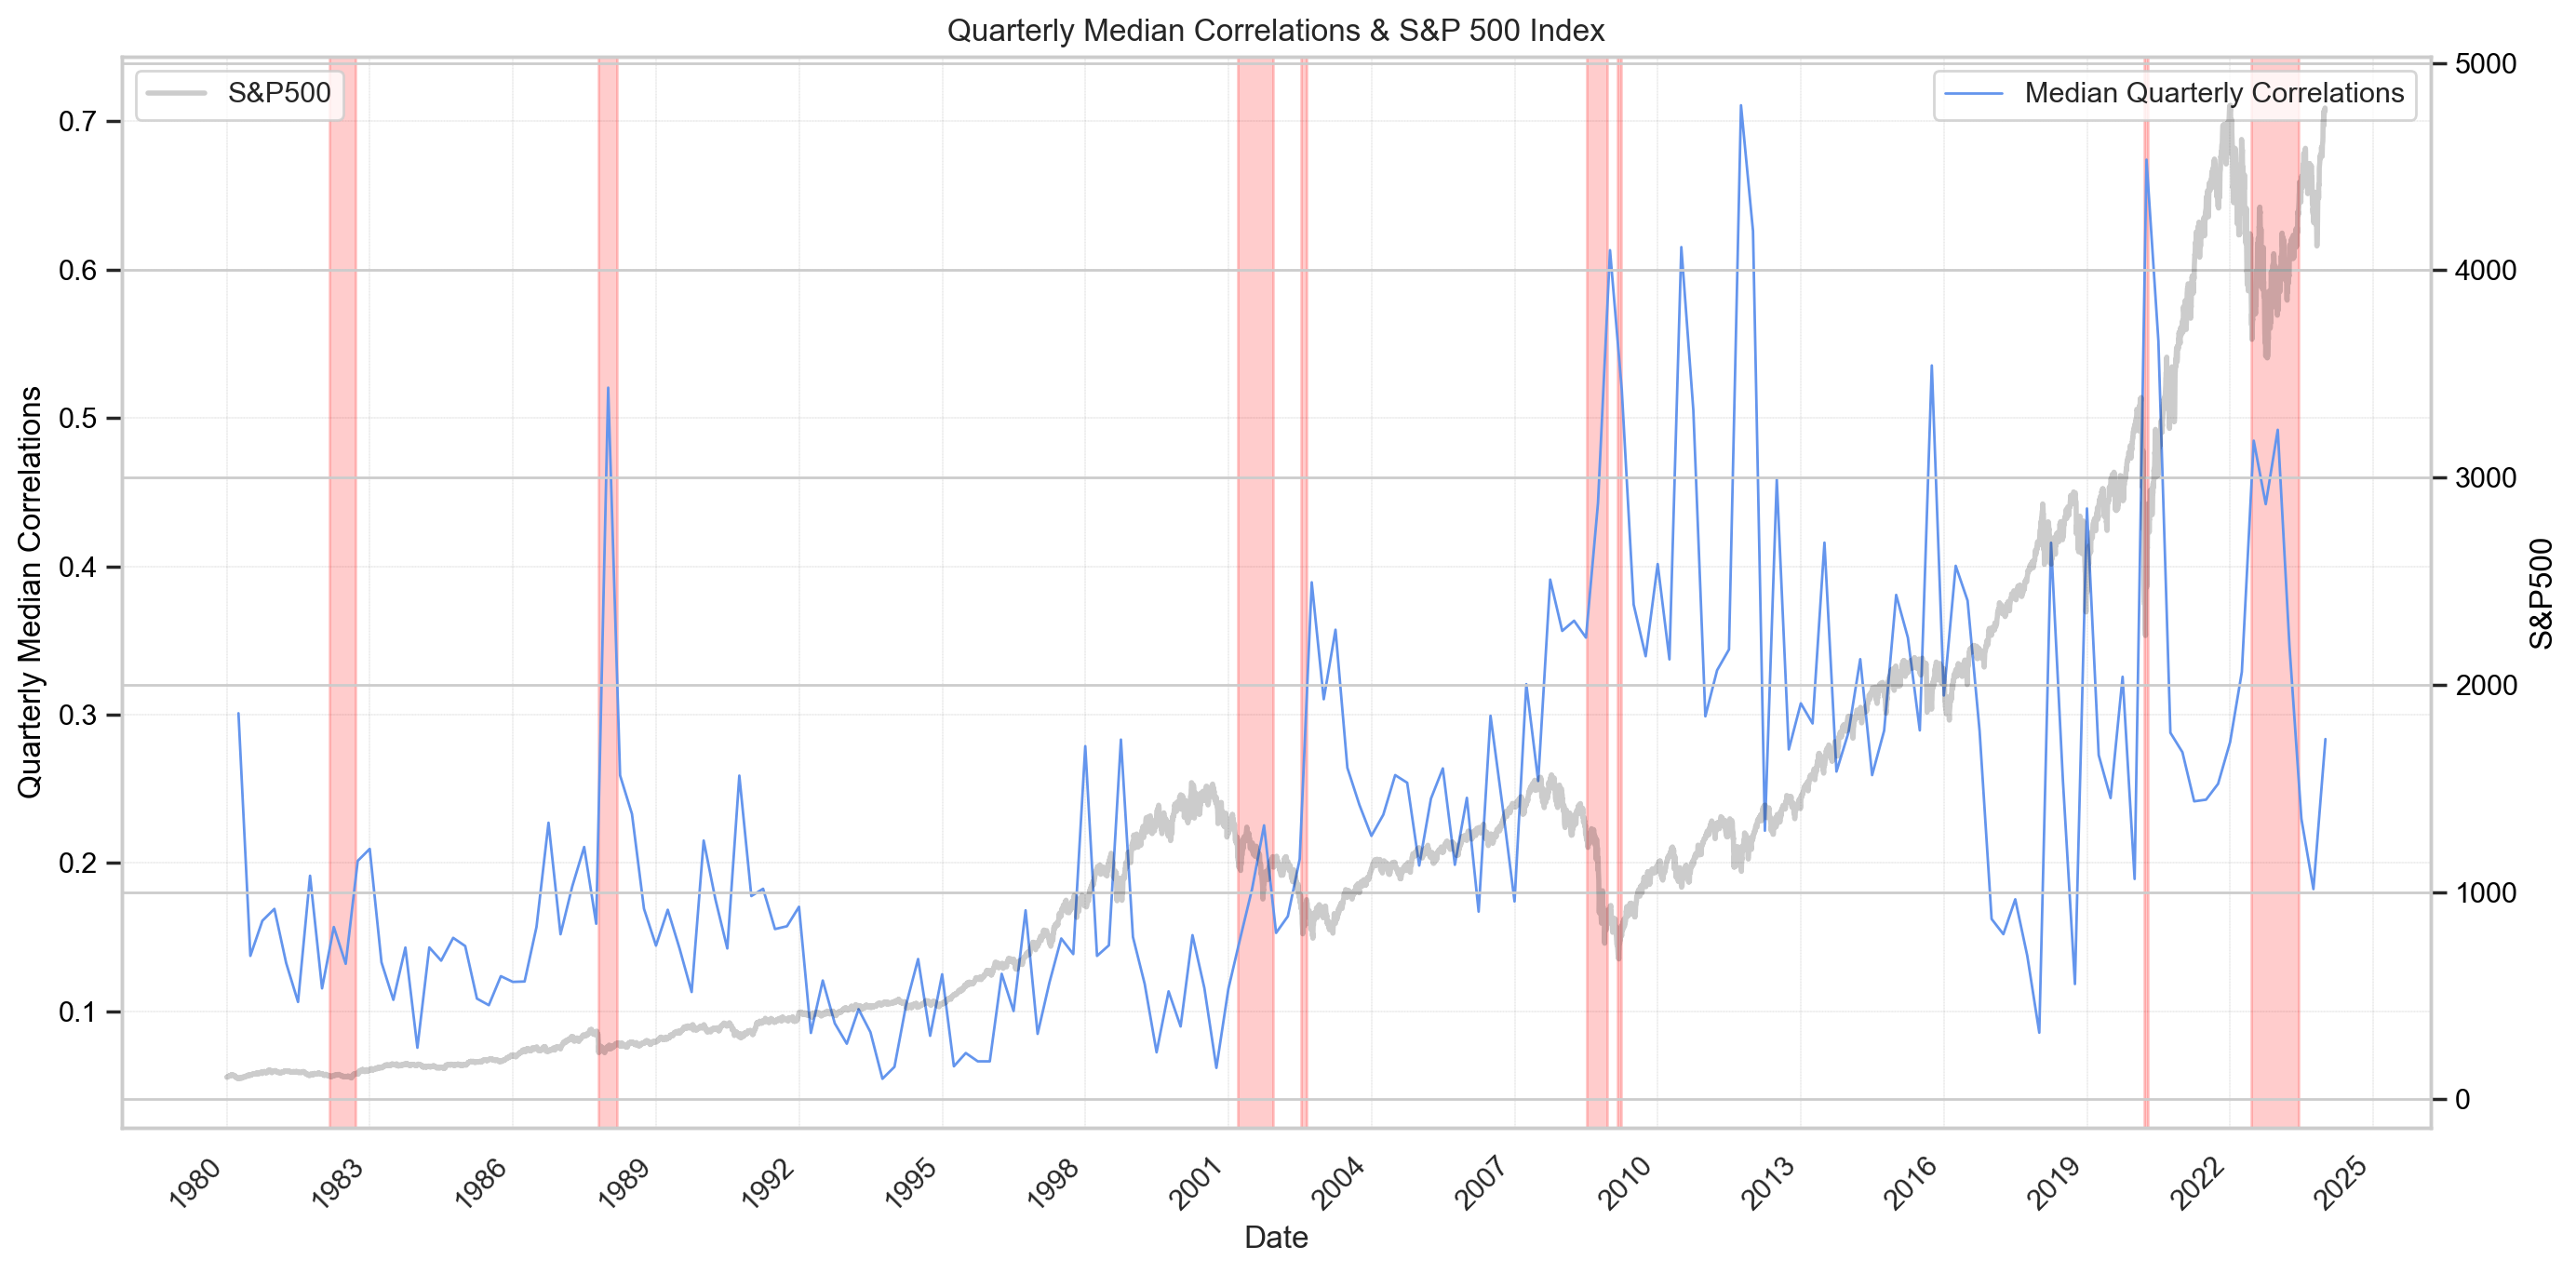

In [8]:
# QUARTERLY Median
quarterly_median_correlations = sp500.iloc[:,:-2].groupby(pd.Grouper(freq='Q')).apply(
    lambda x: x.corr().mask(np.triu(np.ones(x.corr().shape), k=0).astype(bool)).stack().median())

fig, ax1 = plt.subplots(figsize=(14, 7), dpi = 200)

# color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Quarterly Median Correlations', color='black')
ax1.plot(quarterly_median_correlations.index, quarterly_median_correlations, color='cornflowerblue', linewidth=1, label = 'Median Quarterly Correlations')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, which='major', linestyle='--', linewidth='0.1', color='grey')
ax1.grid(True, which='minor', linestyle=':', linewidth='0.1', color='grey')

for start, end in crisis_periods:
    ax1.axvspan(start, end, color='red', alpha=0.2)

ax2 = ax1.twinx()  
ax2.set_ylabel('S&P500', color='black')  
ax2.plot(sp500['^GSPC'].index, sp500['^GSPC'], color='black', linewidth = 2, alpha = 0.2, label = 'S&P500')
ax2.tick_params(axis='y', labelcolor='black')

ax2.legend(loc='upper left')
ax1.legend(loc='upper right')

ax1.xaxis.set_major_locator(mdates.YearLocator(3))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

plt.title("Quarterly Median Correlations & S&P 500 Index")
plt.tight_layout()
plt.show()



## Median Analysis
1.	We have numerous data points clustering around our mean.
2.	The median does not reveal any noticeable differences compared to our mean analysis.


{{< pagebreak >}}
## Maximum and Minimum correlations
1.	There's a lot of noise in our data, but it's interesting to see the maximum and minimum correlations in unison. This seems to be tied to the market's mood swinging between bullish and bearish.
2.	After 2005, our data shows that there's consistently at least one pair of stocks with a perfect correlation. This is likely because we're analyzing almost 400 stocks, compared to fewer in earlier periods, out of a total of 503.
3.	The spike in 2013 is linked to the "[taper tantrum](https://www.investopedia.com/terms/t/taper-tantrum.asp)" when the Fed hinted at tapering its bond-buying program which was started after the 2008 financial crisis. This suggested a reduction in market liquidity, leading to outflow of funds from the market. The maximum correlation stayed at 1, but the minimum correlation dipped, reflecting this market behavior.

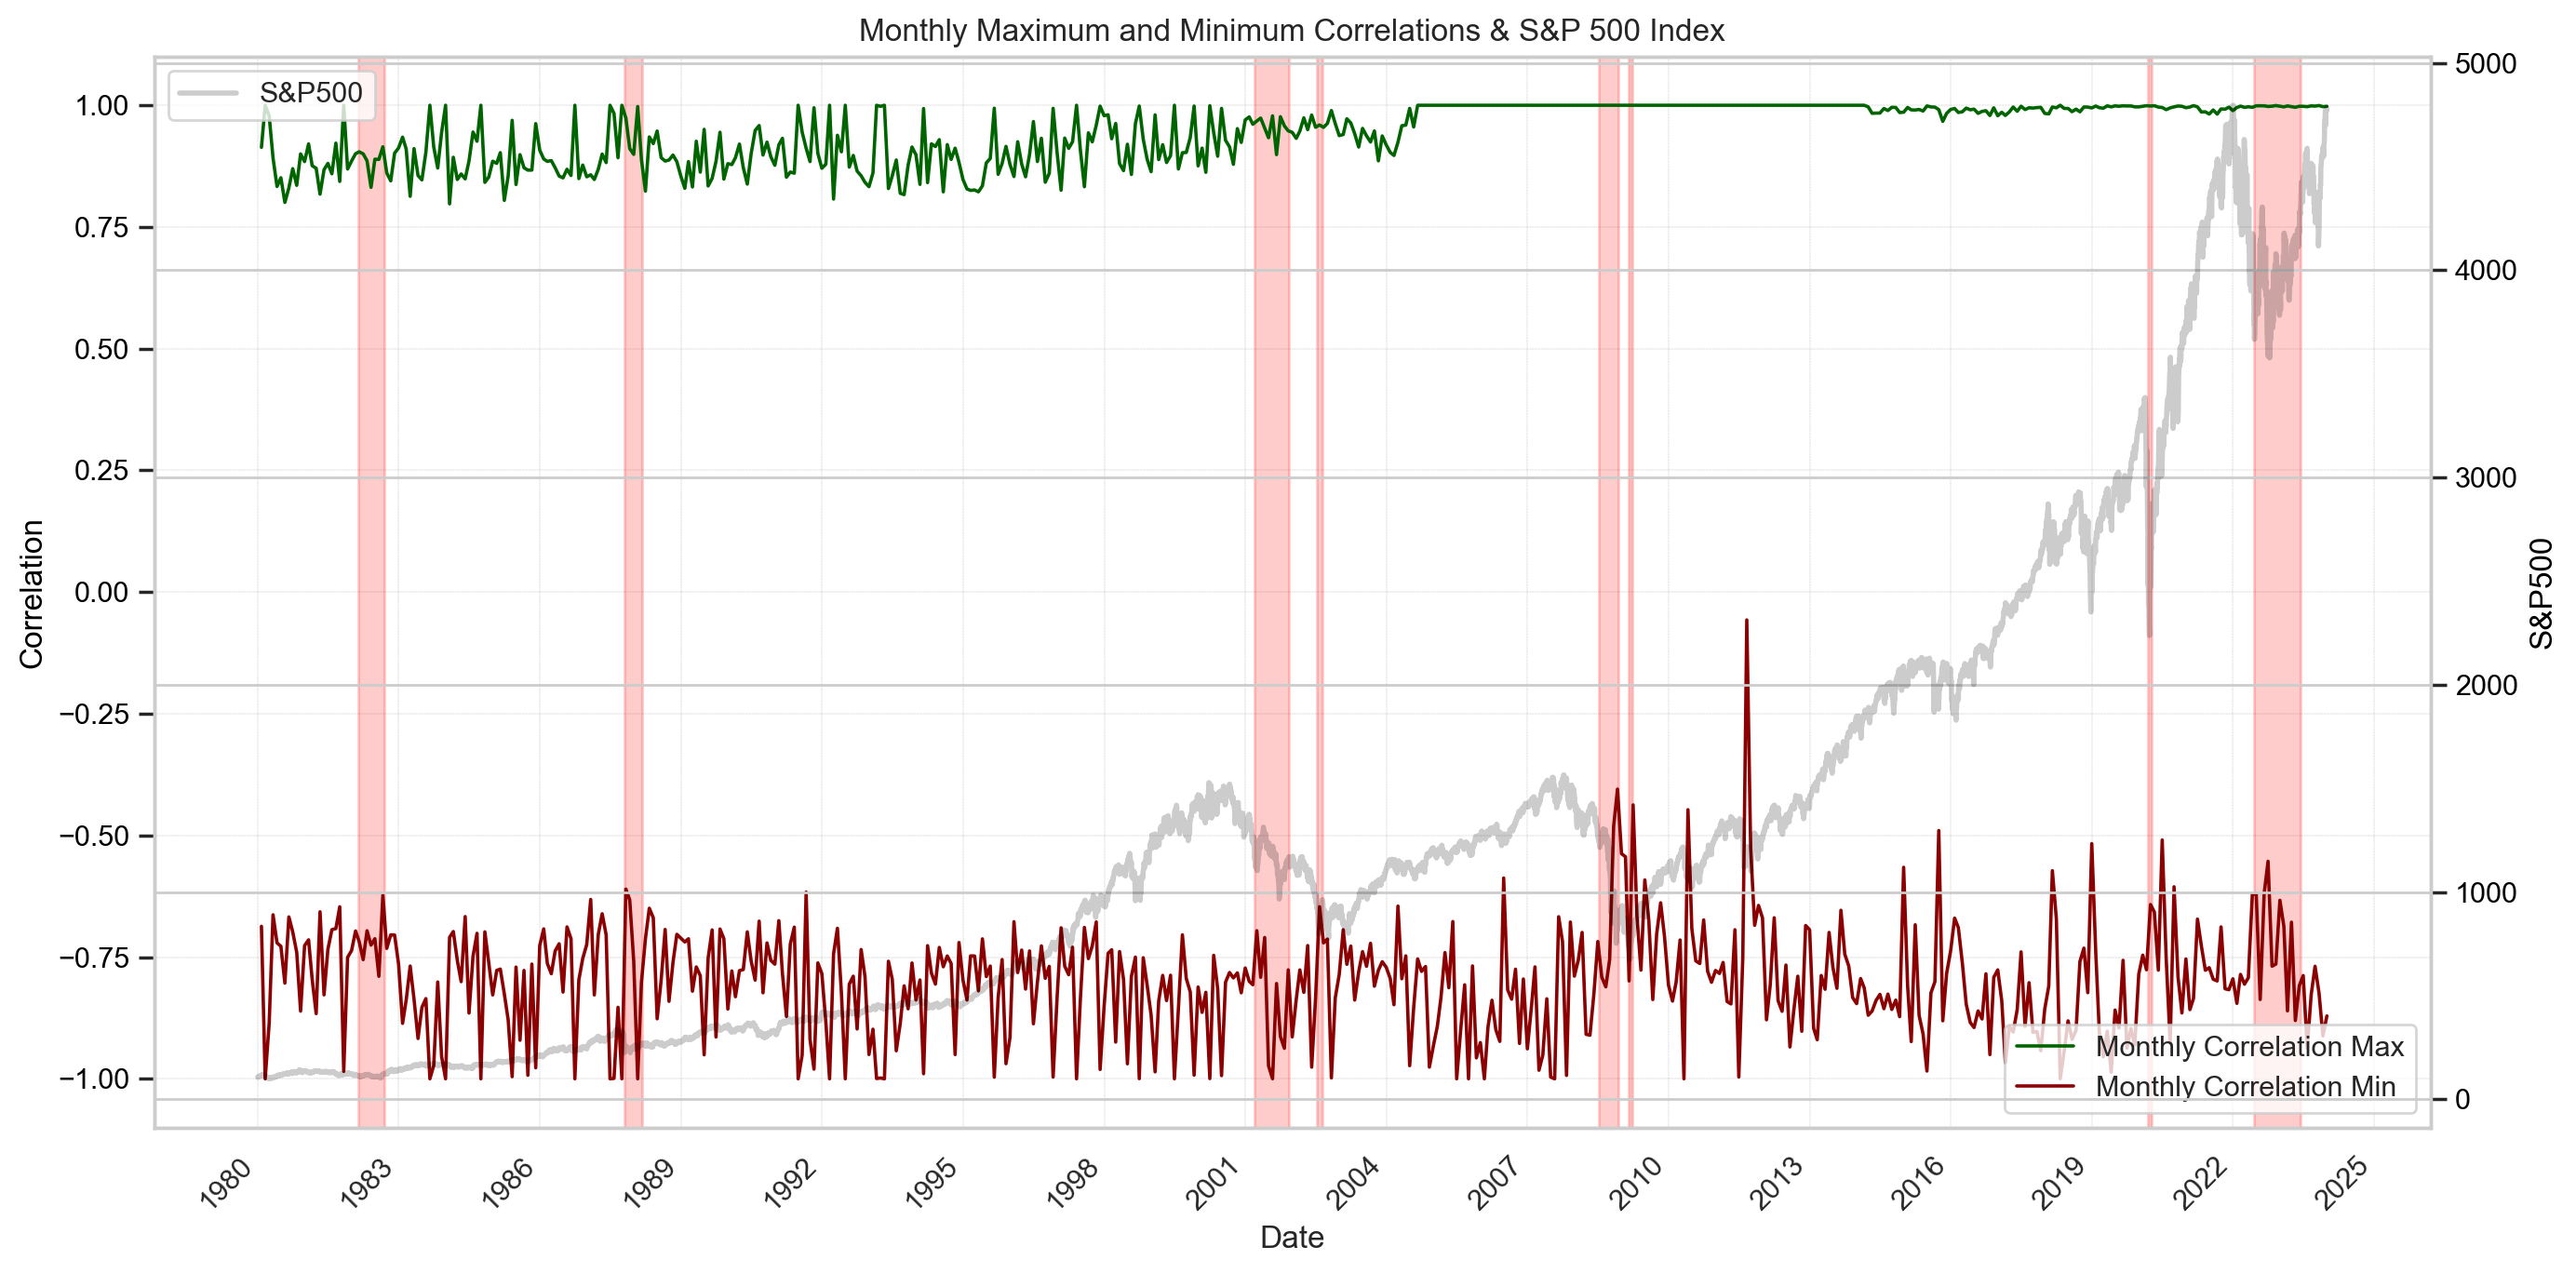

In [9]:
# MAX
monthly_correlations_max = sp500.iloc[:,:-2].groupby(pd.Grouper(freq='M')).apply(
    lambda x: x.corr().mask(np.triu(np.ones(x.corr().shape), k=0).astype(bool)).stack().max())

# MIN
monthly_correlations_min = sp500.iloc[:,:-2].groupby(pd.Grouper(freq='M')).apply(
    lambda x: x.corr().mask(np.triu(np.ones(x.corr().shape), k=0).astype(bool)).stack().min())

fig, ax1 = plt.subplots(figsize=(14, 7), dpi = 200)

# color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Correlation', color='black')
ax1.plot(monthly_correlations_max.index, monthly_correlations_max, color='darkgreen', linewidth=1.3, label = 'Monthly Correlation Max')
ax1.plot(monthly_correlations_min.index, monthly_correlations_min, color='darkred', linewidth=1.3, label = 'Monthly Correlation Min')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, which='major', linestyle='--', linewidth='0.1', color='grey')
ax1.grid(True, which='minor', linestyle=':', linewidth='0.1', color='grey')

for start, end in crisis_periods:
    ax1.axvspan(start, end, color='red', alpha=0.2)

ax2 = ax1.twinx()  
ax2.set_ylabel('S&P500', color='black')  
ax2.plot(sp500['^GSPC'].index, sp500['^GSPC'], color='black', linewidth = 2, alpha = 0.2, label = 'S&P500')
ax2.tick_params(axis='y', labelcolor='black')

ax1.xaxis.set_major_locator(mdates.YearLocator(3))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

ax2.legend(loc='upper left')
ax1.legend(loc='lower right')

plt.title("Monthly Maximum and Minimum Correlations & S&P 500 Index")
plt.tight_layout()
plt.show()

{{< pagebreak >}}
## Standard deviation and covariance
1.	Given the significant noise in our data, we have studied this by plotting both standard deviation and covariance.
2.	The standard deviation supports our initial theory that crises often begin with panic selling by market participants. However, a spike in covariance reveals that, despite the diversity of industries within the S&P 500, a bearish market sentiment prevails, resulting in higher covariances.


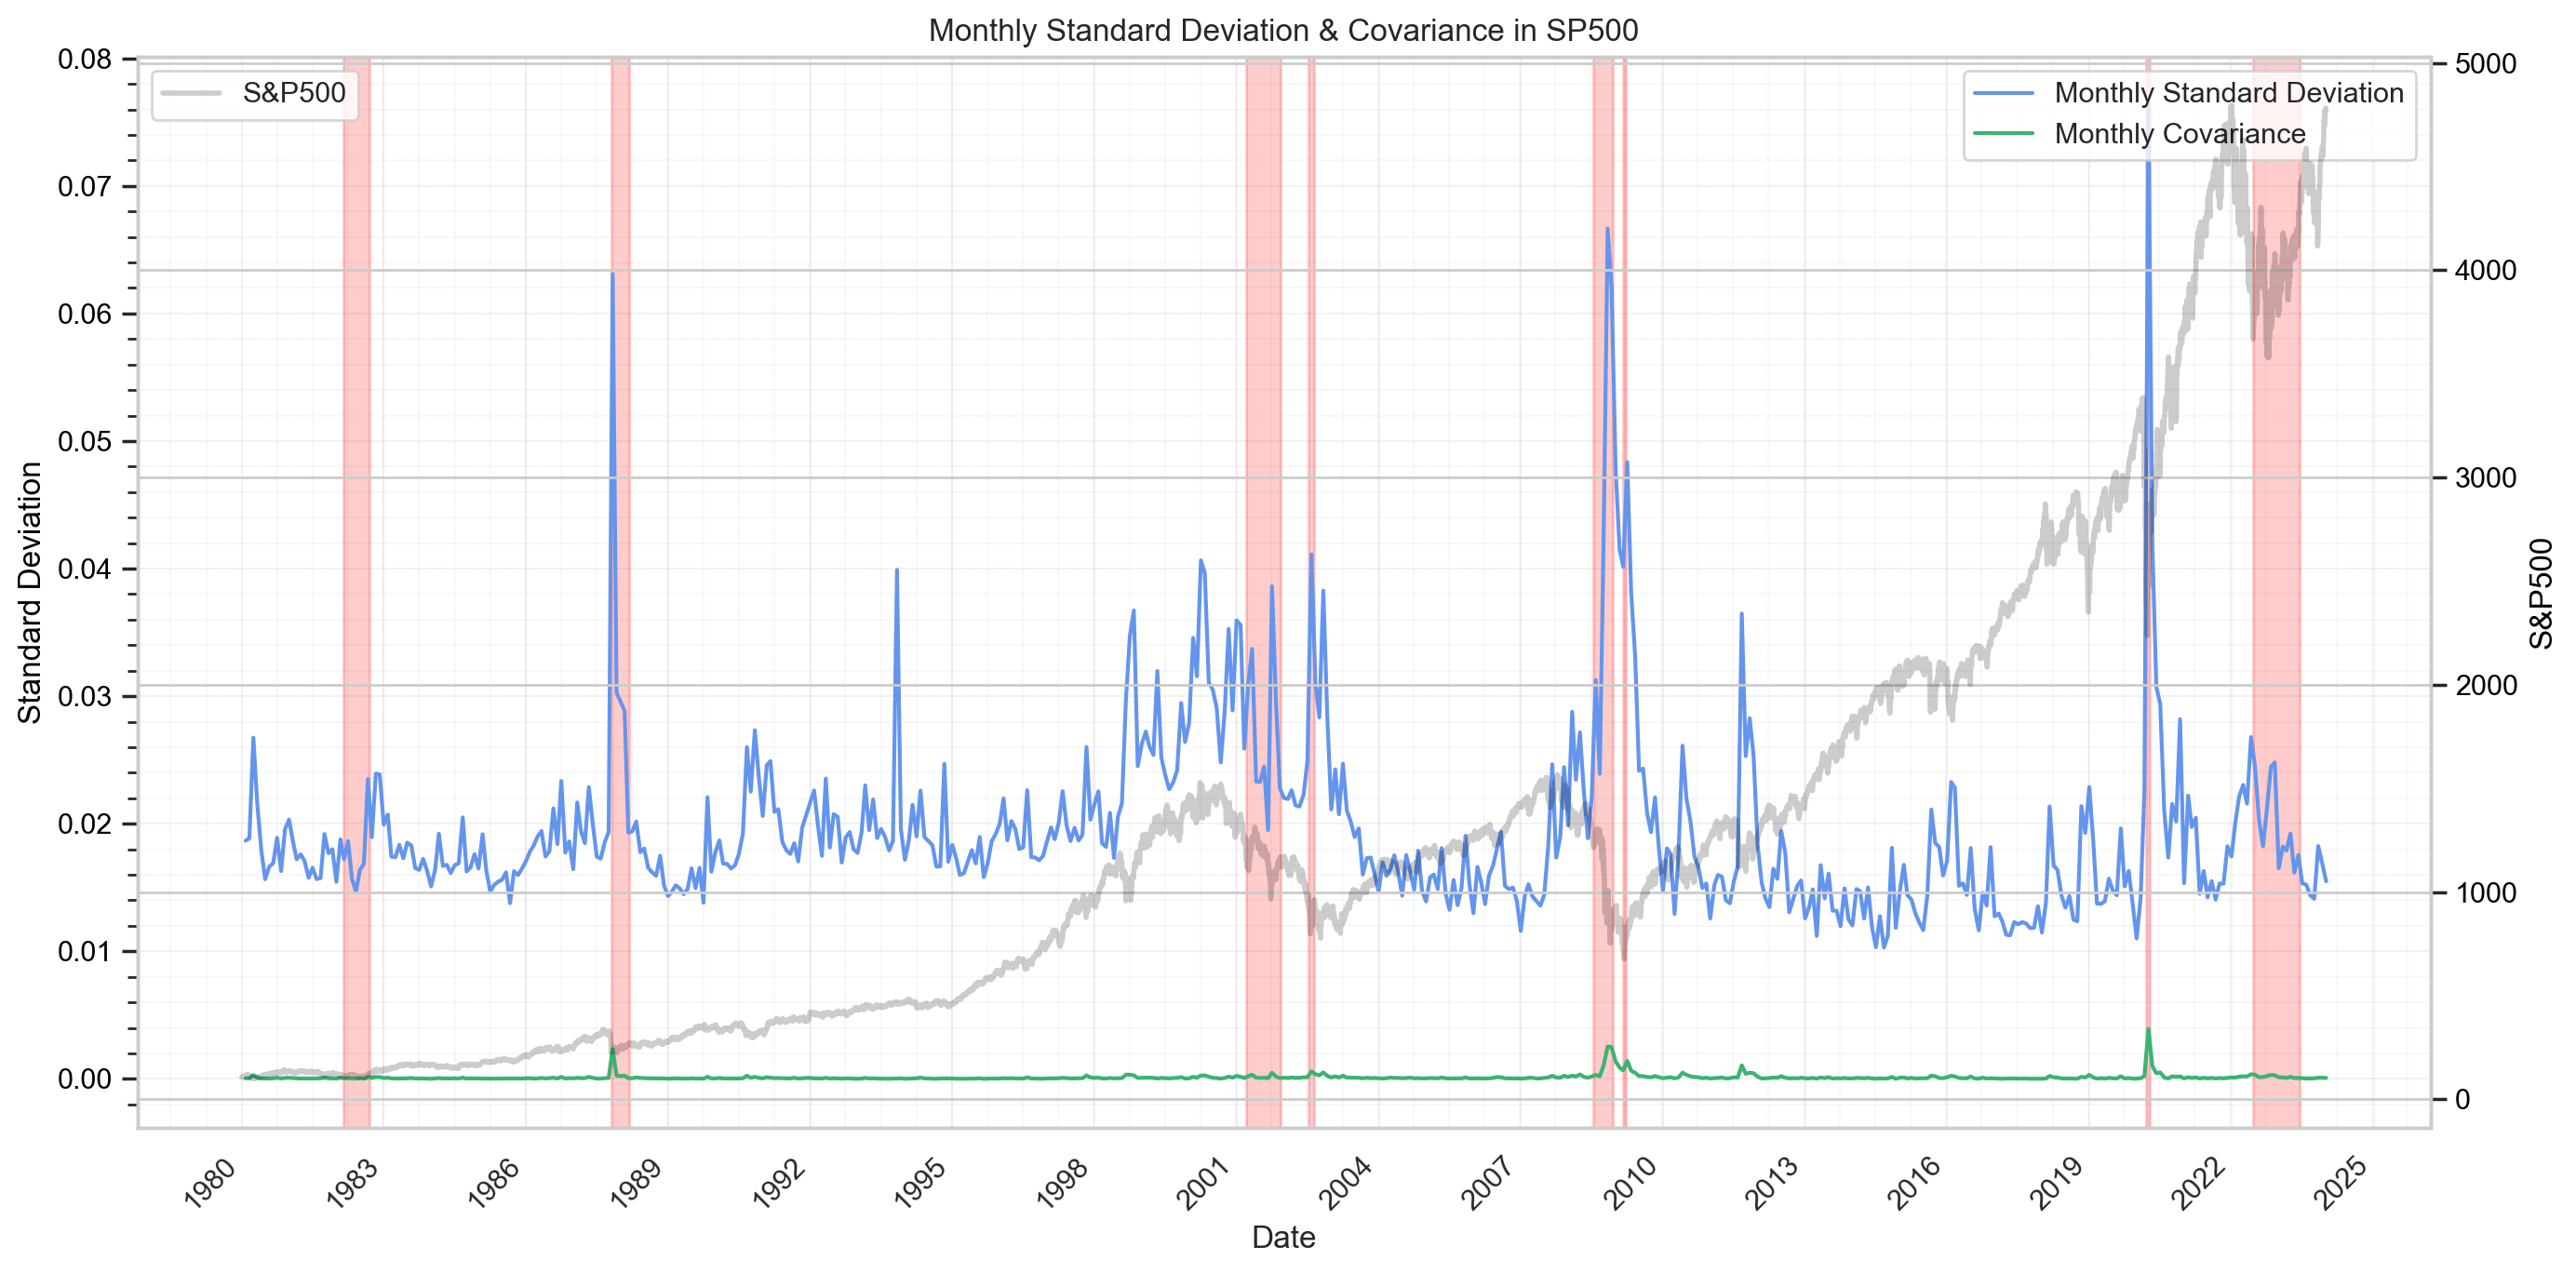

In [10]:
# Standard Deviation and Covariance
monthly_std = sp500.iloc[:,:-2].groupby(pd.Grouper(freq='M')).apply(lambda x: x.std().mean())

monthly_covar = sp500.iloc[:,:-2].groupby(pd.Grouper(freq='M')).apply(
    lambda x: x.cov().mask(np.triu(np.ones(x.cov().shape), k=0).astype(bool)).stack().mean())

fig, ax1 = plt.subplots(figsize=(14, 7), dpi = 200)

# color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Standard Deviation', color='black')
ax1.plot(monthly_std.index, monthly_std, color='cornflowerblue', linewidth=1.5, label = 'Monthly Standard Deviation')
ax1.plot(monthly_covar.index, monthly_covar, color='mediumseagreen', linewidth=1.5, label = 'Monthly Covariance')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, which='major', linestyle='--', linewidth='0.1', color='grey')
ax1.grid(True, which='minor', linestyle=':', linewidth='0.1', color='grey')
ax1.minorticks_on()

for start, end in crisis_periods:
    ax1.axvspan(start, end, color='red', alpha=0.2)

ax2 = ax1.twinx()  
ax2.set_ylabel('S&P500', color='black')  
ax2.plot(sp500['^GSPC'].index, sp500['^GSPC'], color='black', linewidth = 2, alpha = 0.2, label = 'S&P500')
ax2.tick_params(axis='y', labelcolor='black')

ax1.xaxis.set_major_locator(mdates.YearLocator(3))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

ax2.legend(loc='upper left')
ax1.legend(loc='upper right')

plt.title("Monthly Standard Deviation & Covariance in SP500")
plt.tight_layout()
plt.show()

{{< pagebreak >}}
## Rolling-20 Correlation analysis

In [11]:
new_sp500 = sp500.iloc[:, :-2]

In [12]:
# The cell below takes more than a minute to run. It's a bit like watching a beautiful painting dry, but the wait is worth it.

moving_correlations = {}
window_days = 20

num_rows = len(new_sp500)

for start_idx in range(num_rows - window_days + 1):
    end_idx = start_idx + window_days
    window_data = new_sp500.iloc[start_idx:end_idx]
    
    calc_corr = window_data.corr()
    
    window_corr = calc_corr.mask(
        np.triu(np.ones(calc_corr.shape), k=0).astype(bool)
    ).stack().mean()
    window_end_date = window_data.index[-1]
    moving_correlations[window_end_date] = window_corr
moving_correlations_df = pd.DataFrame(list(moving_correlations.items()), columns=['Date', 'Average Correlation']).set_index('Date')

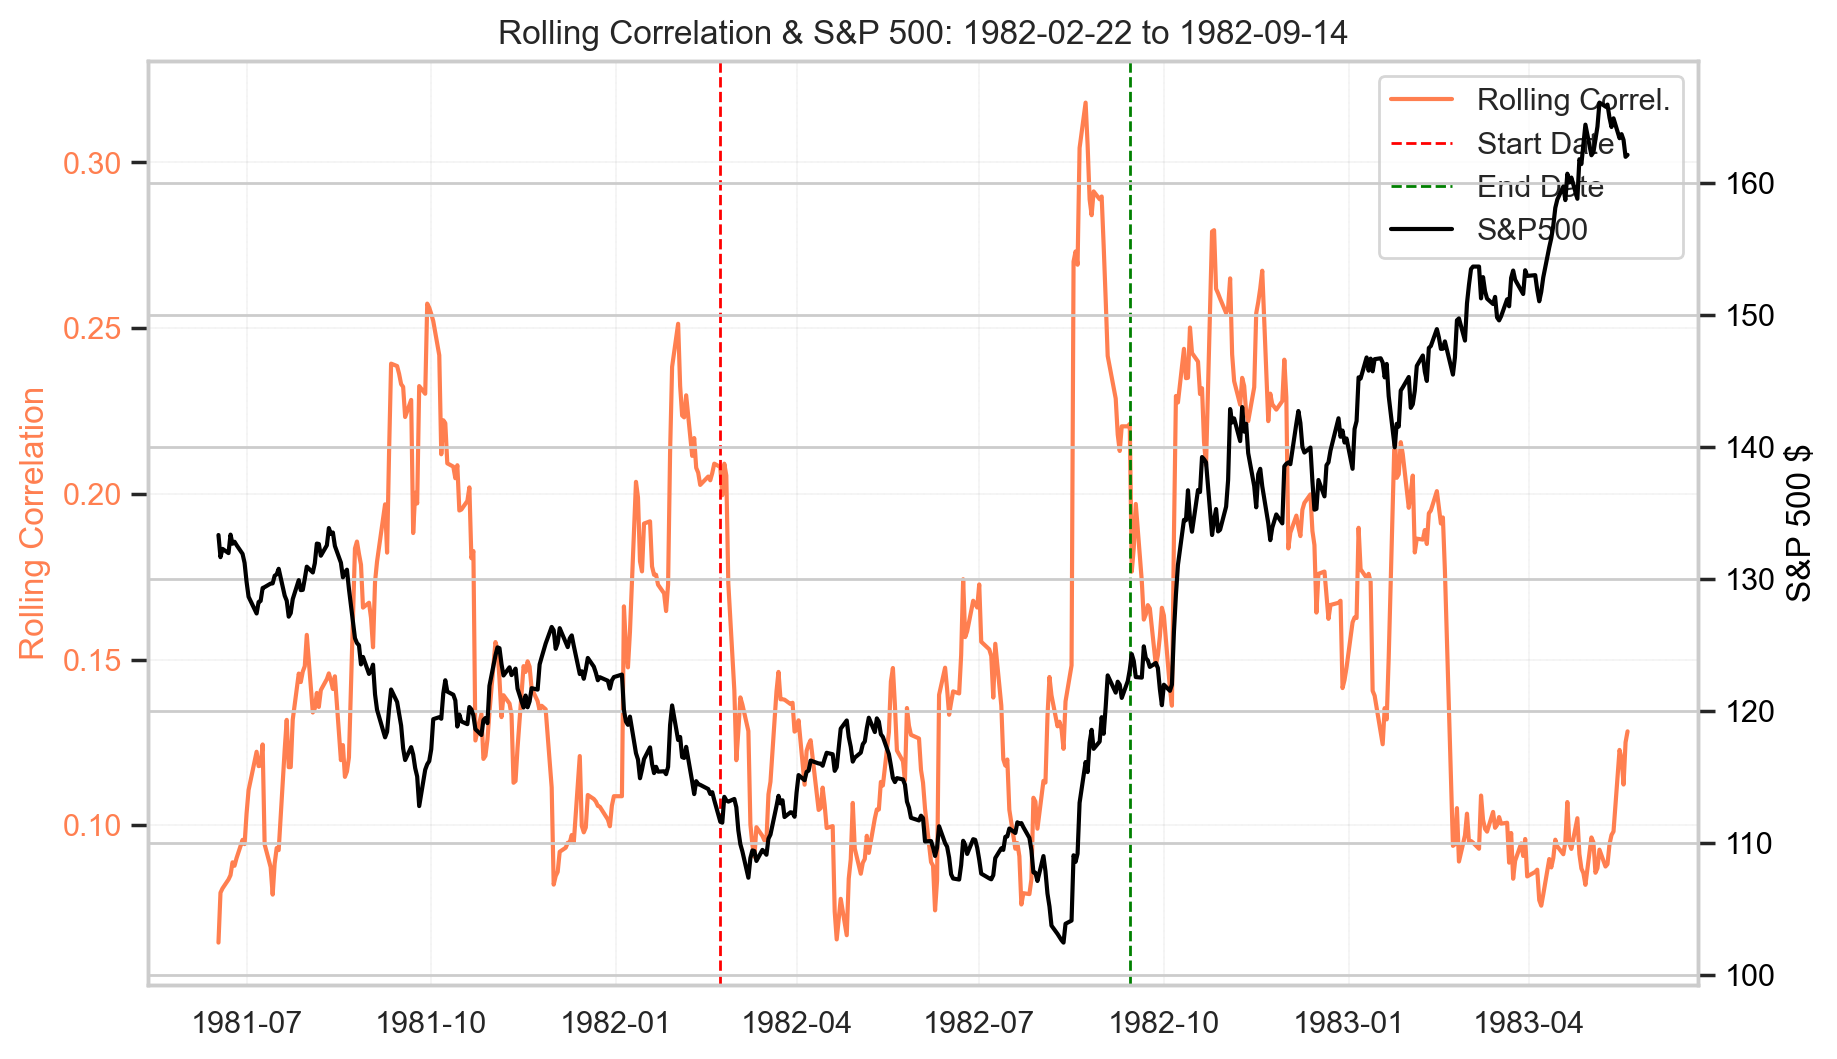

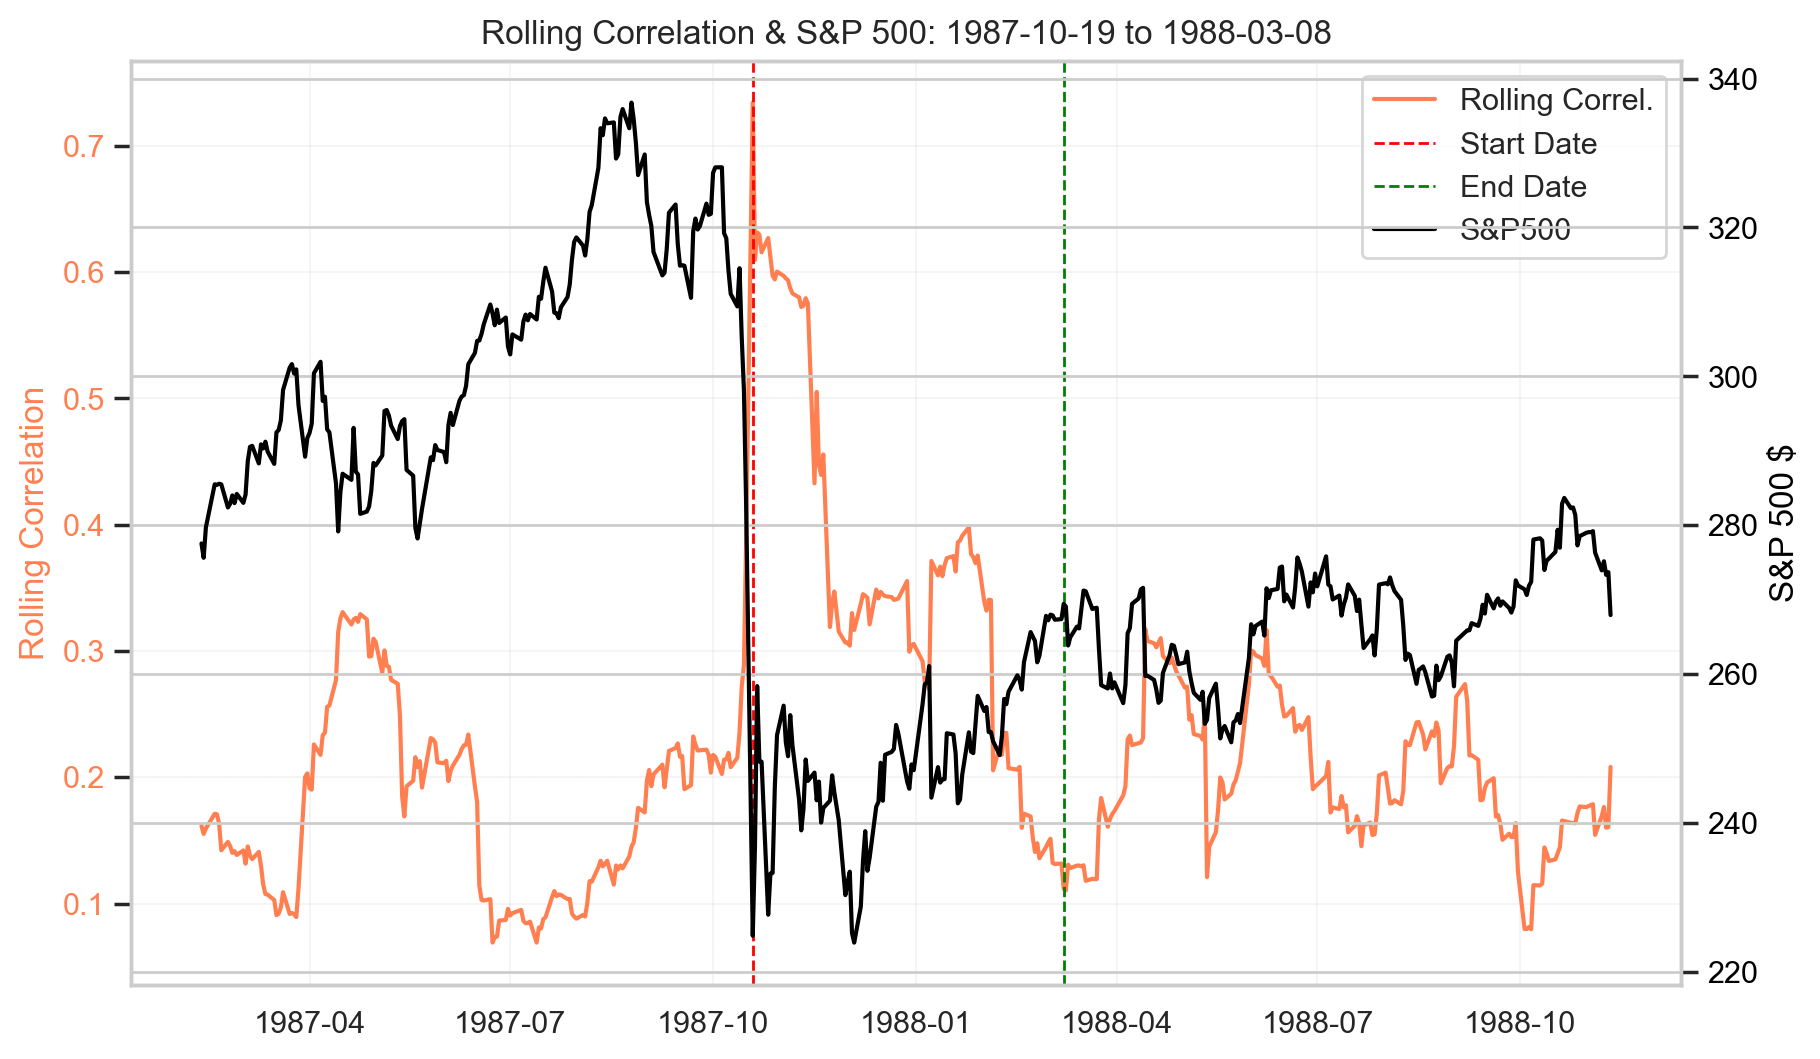

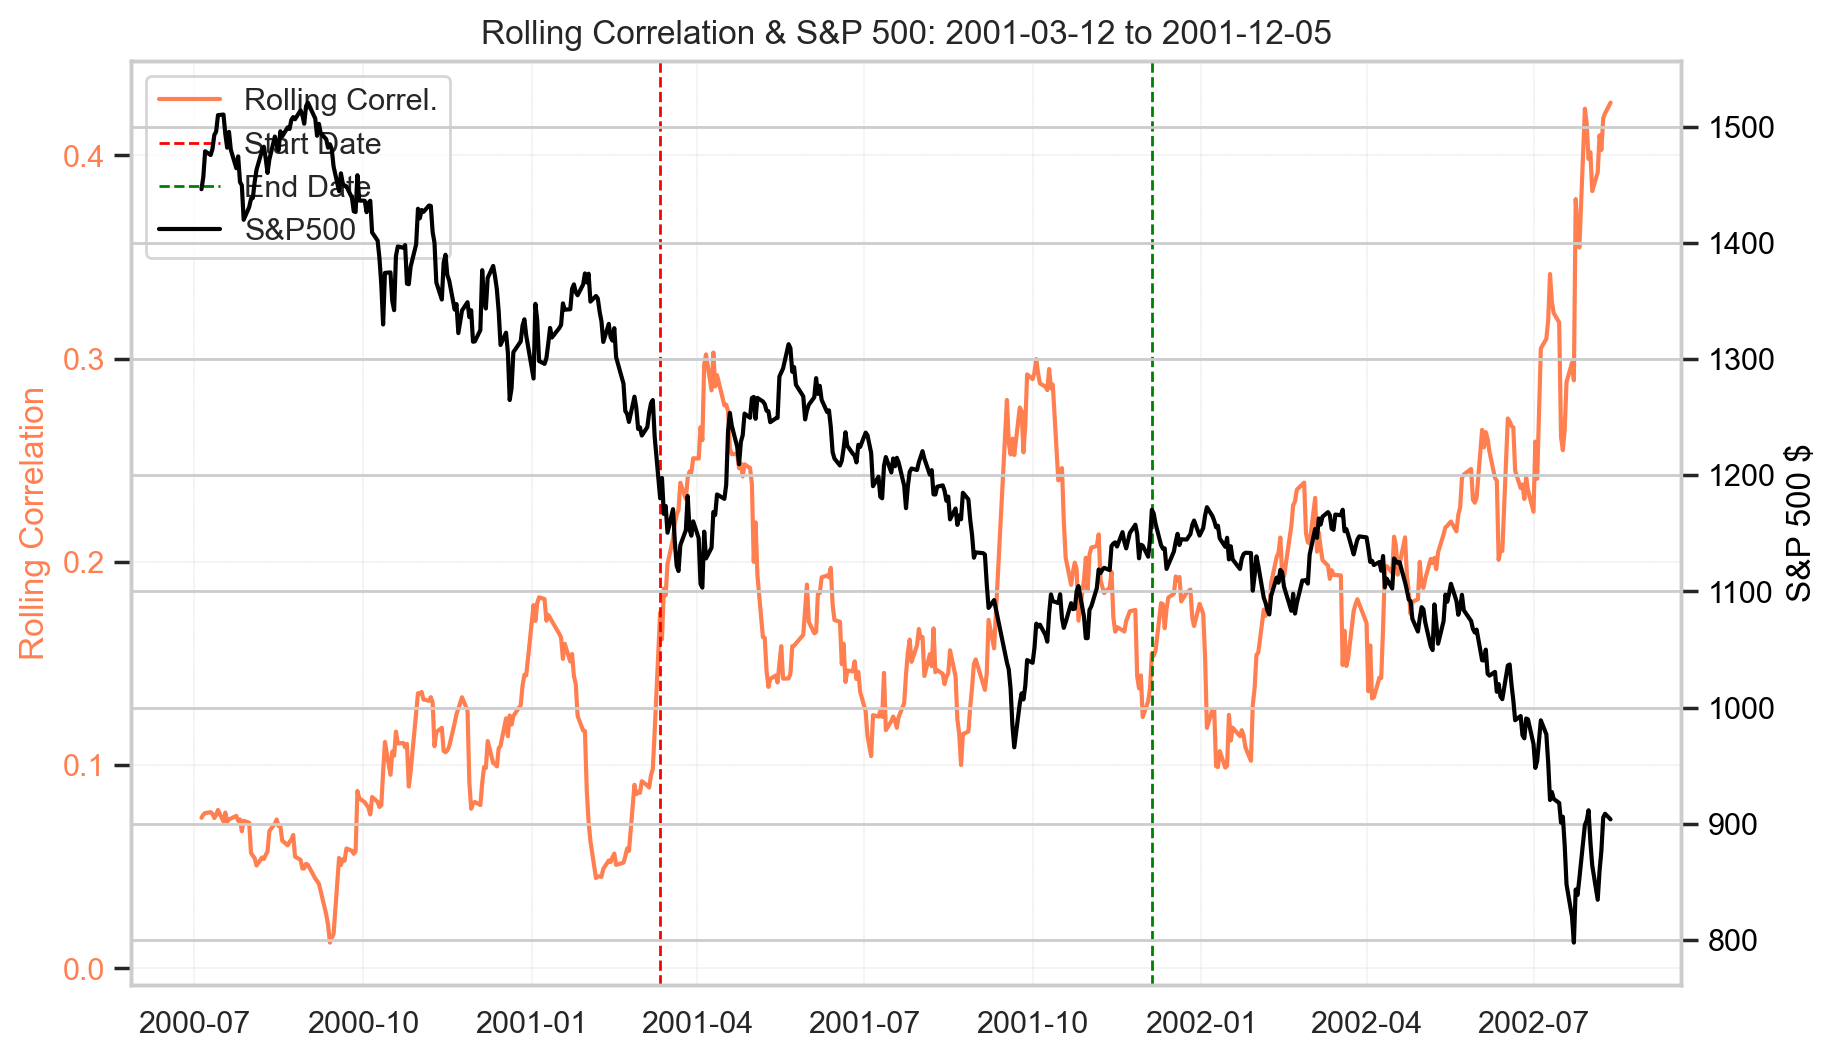

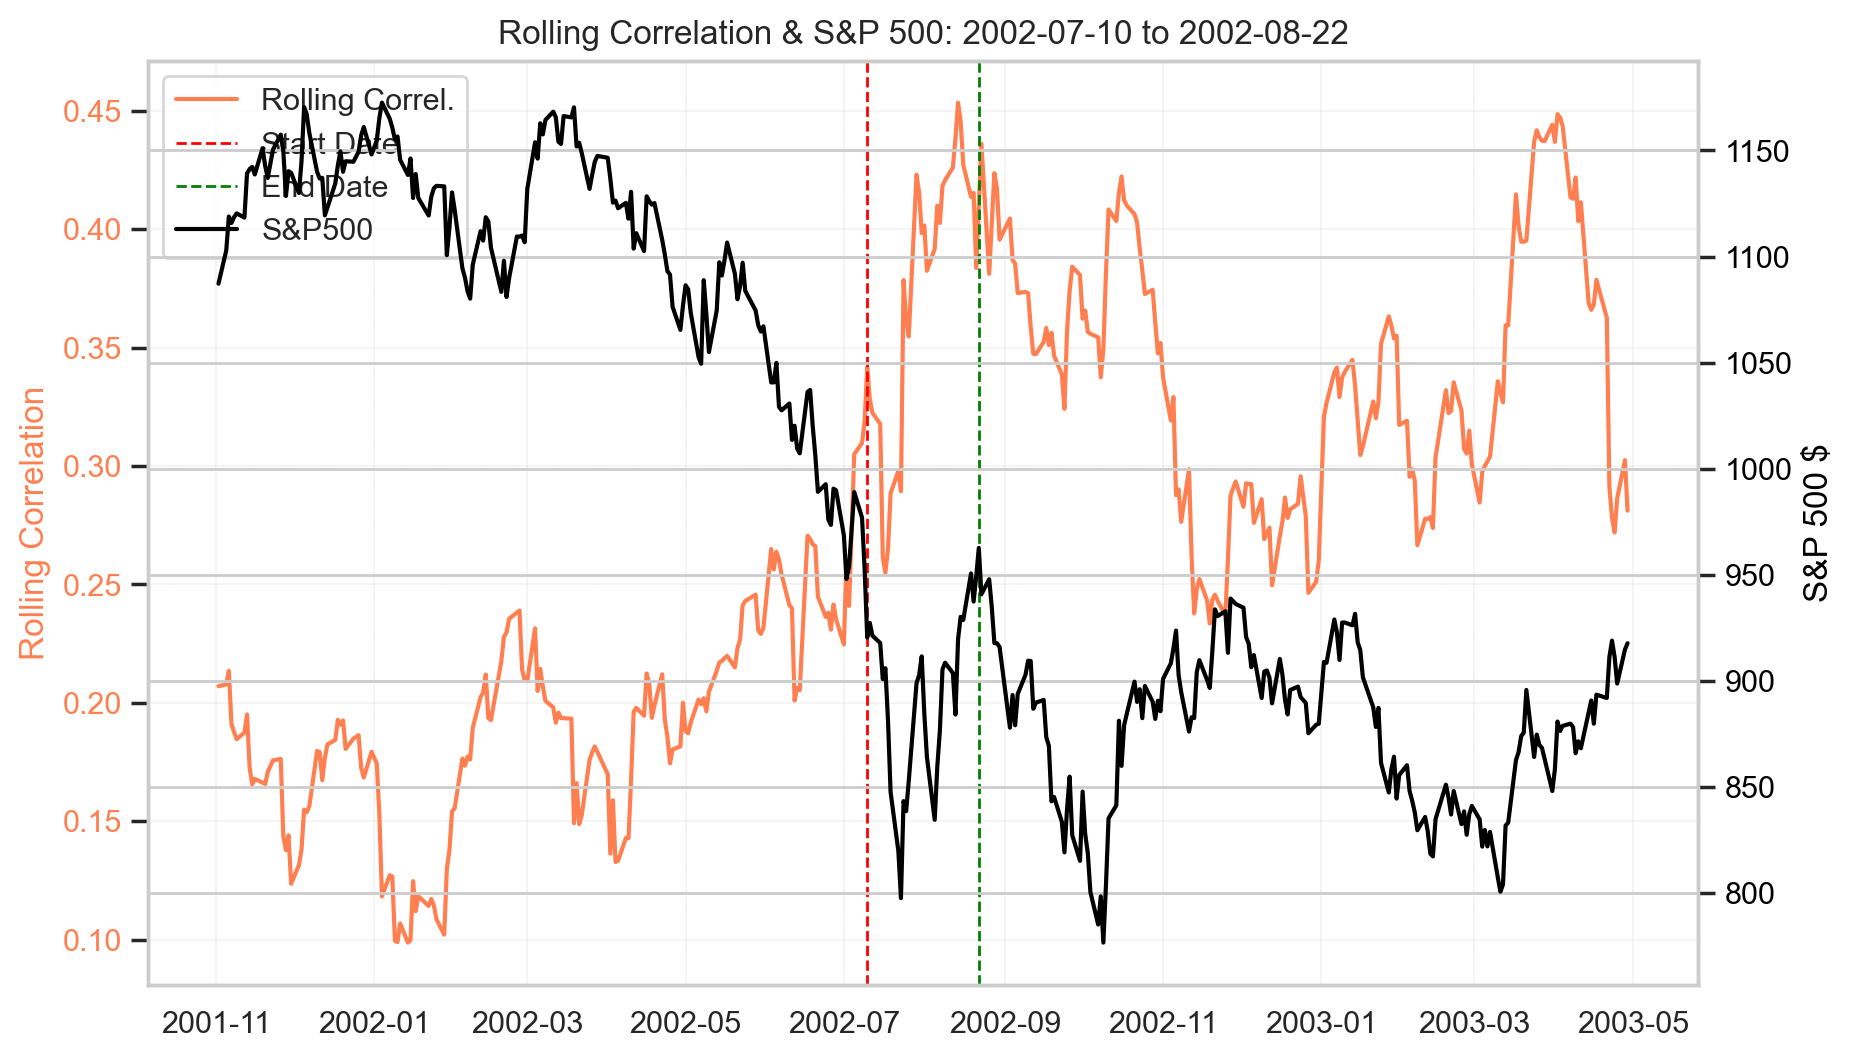

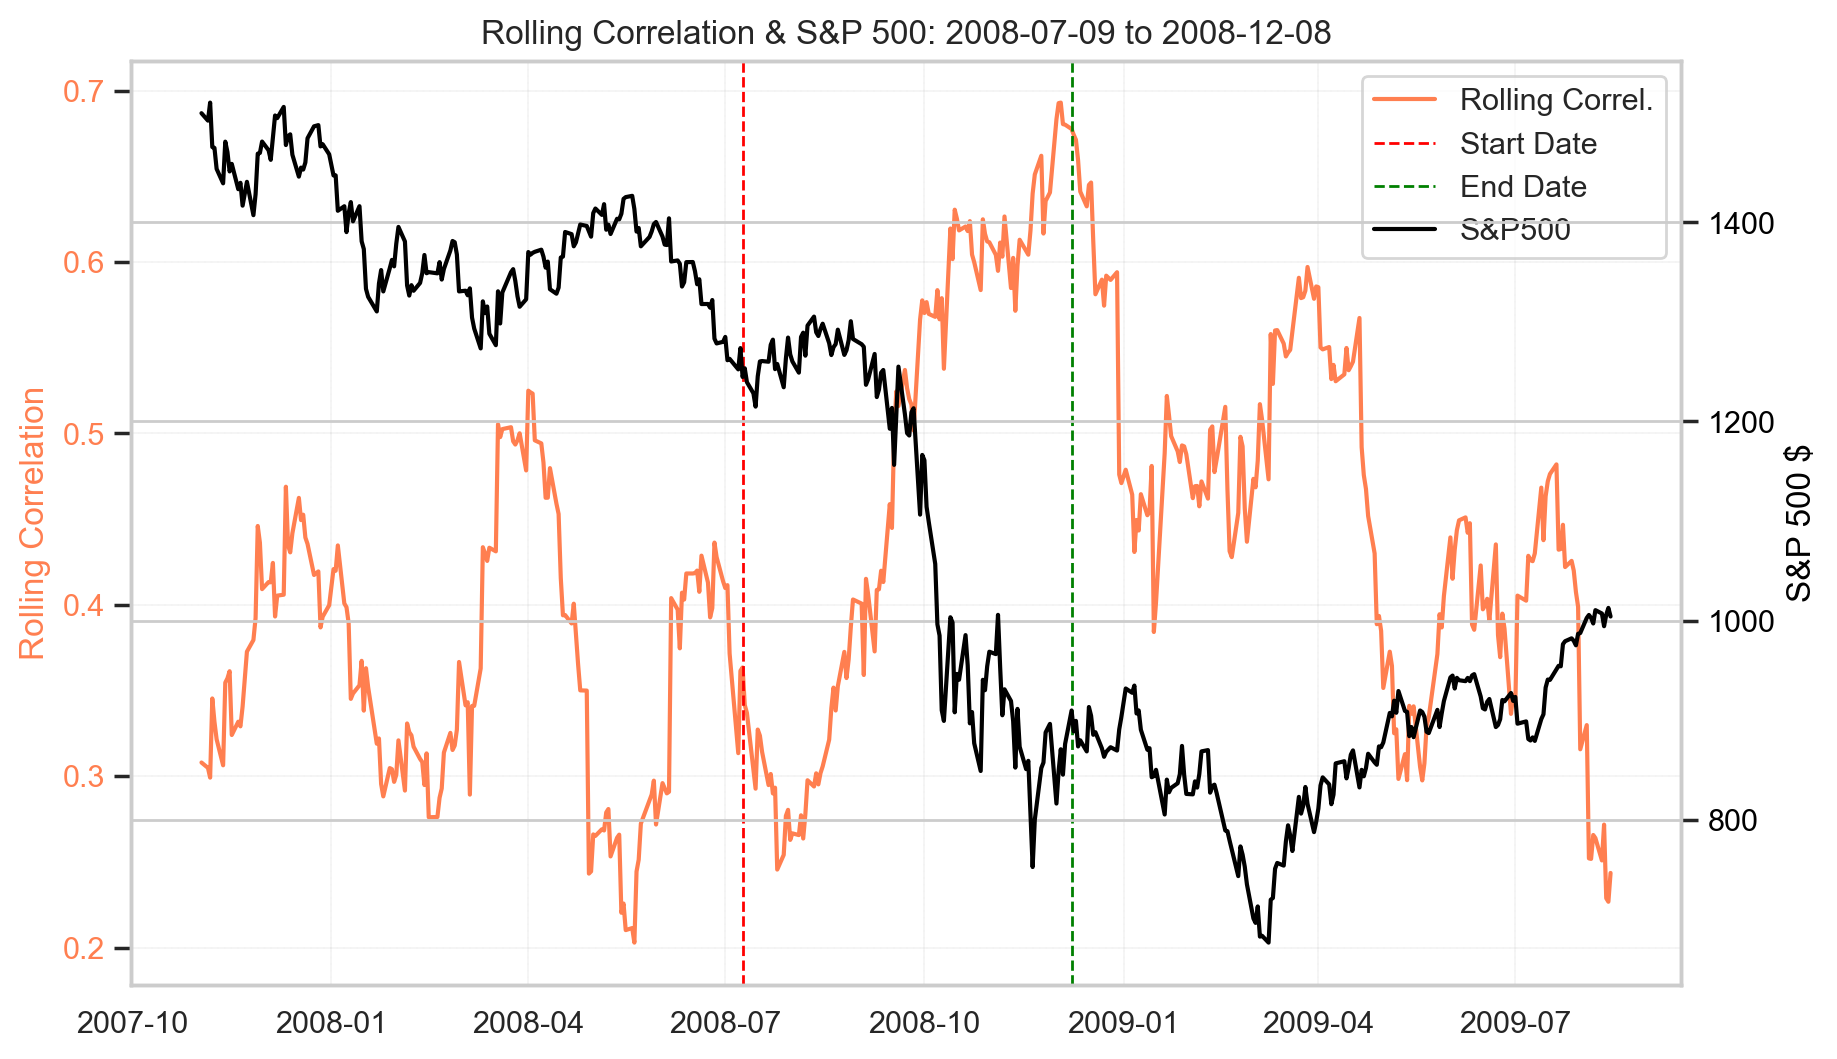

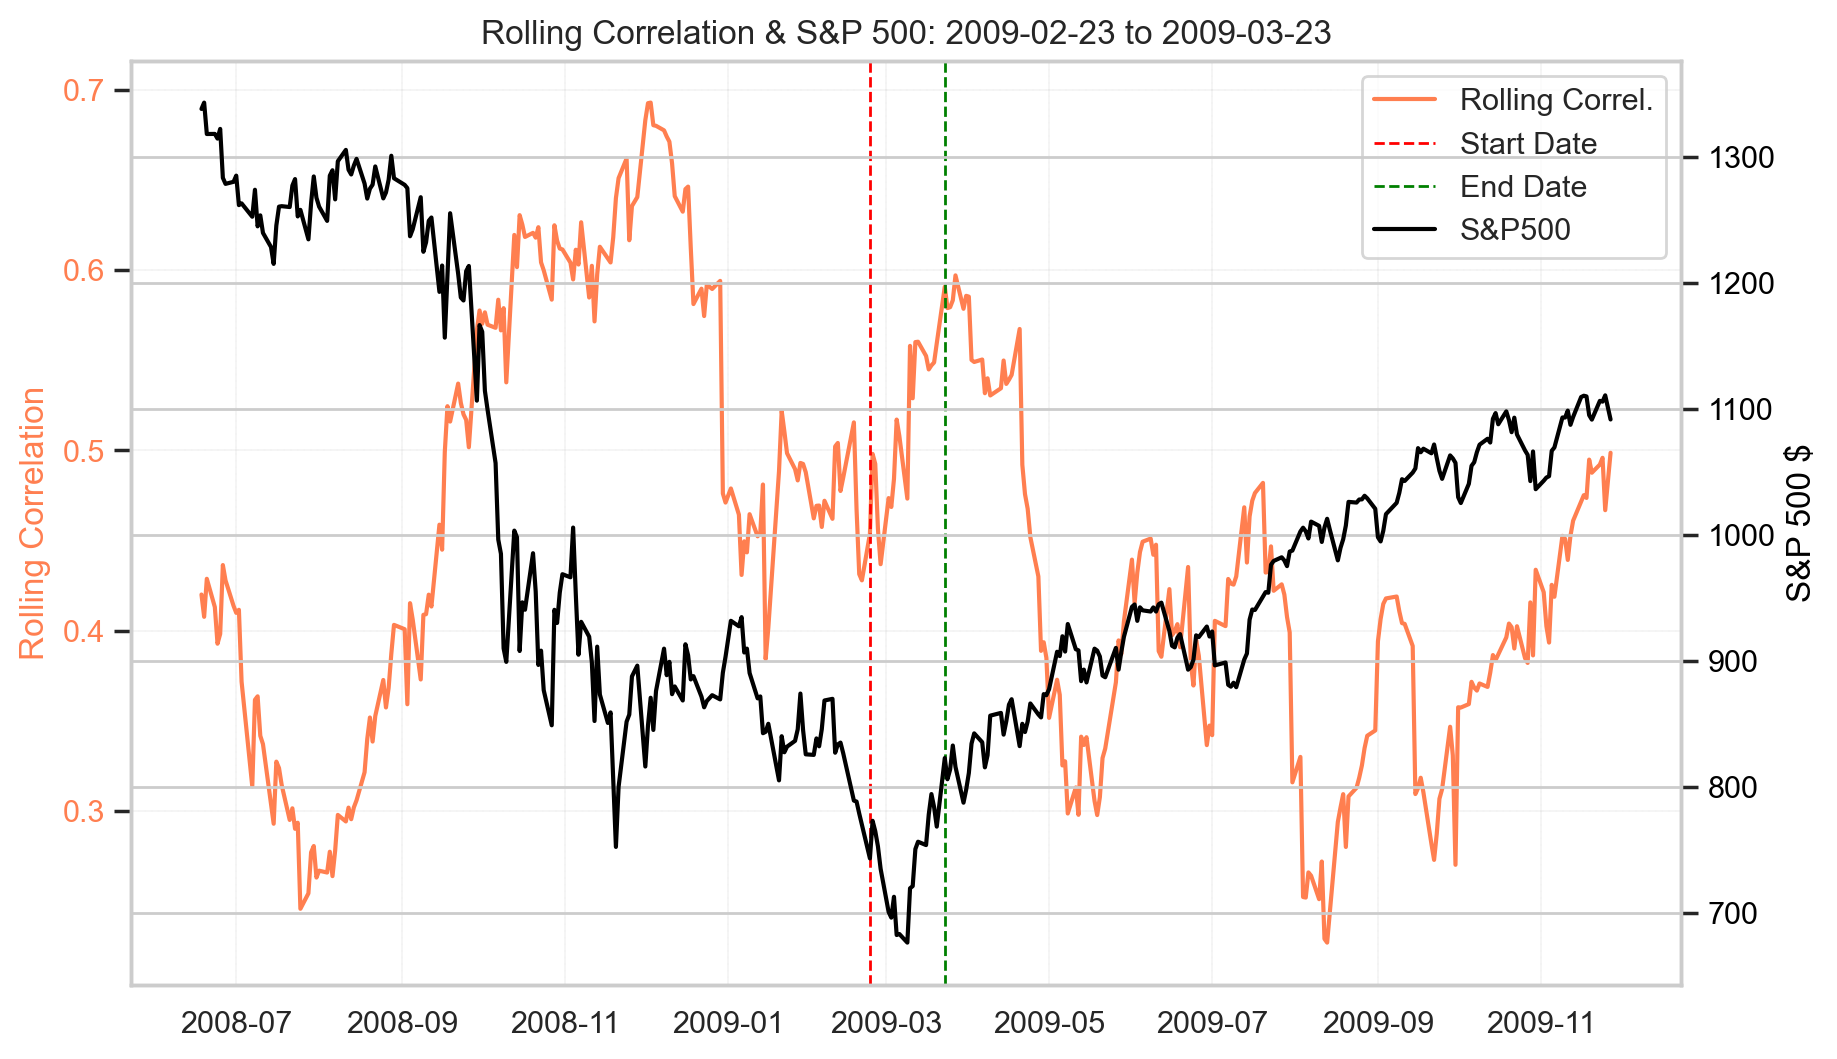

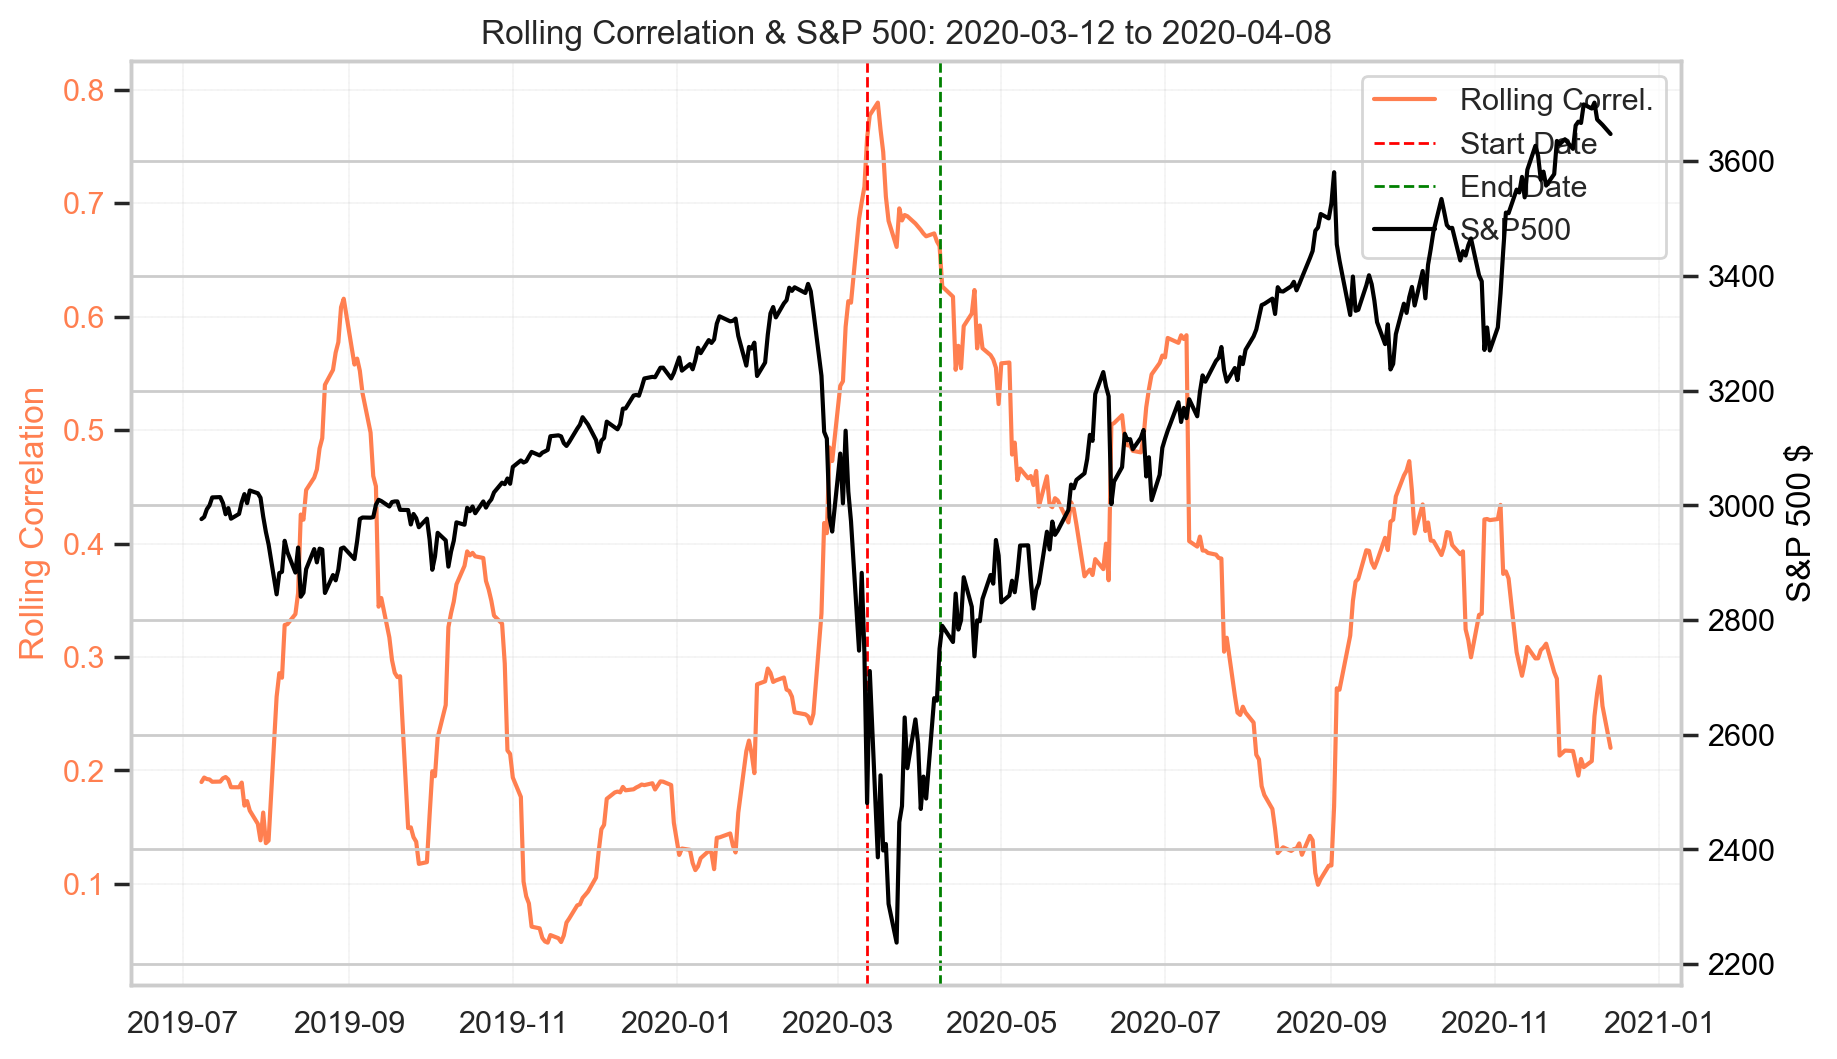

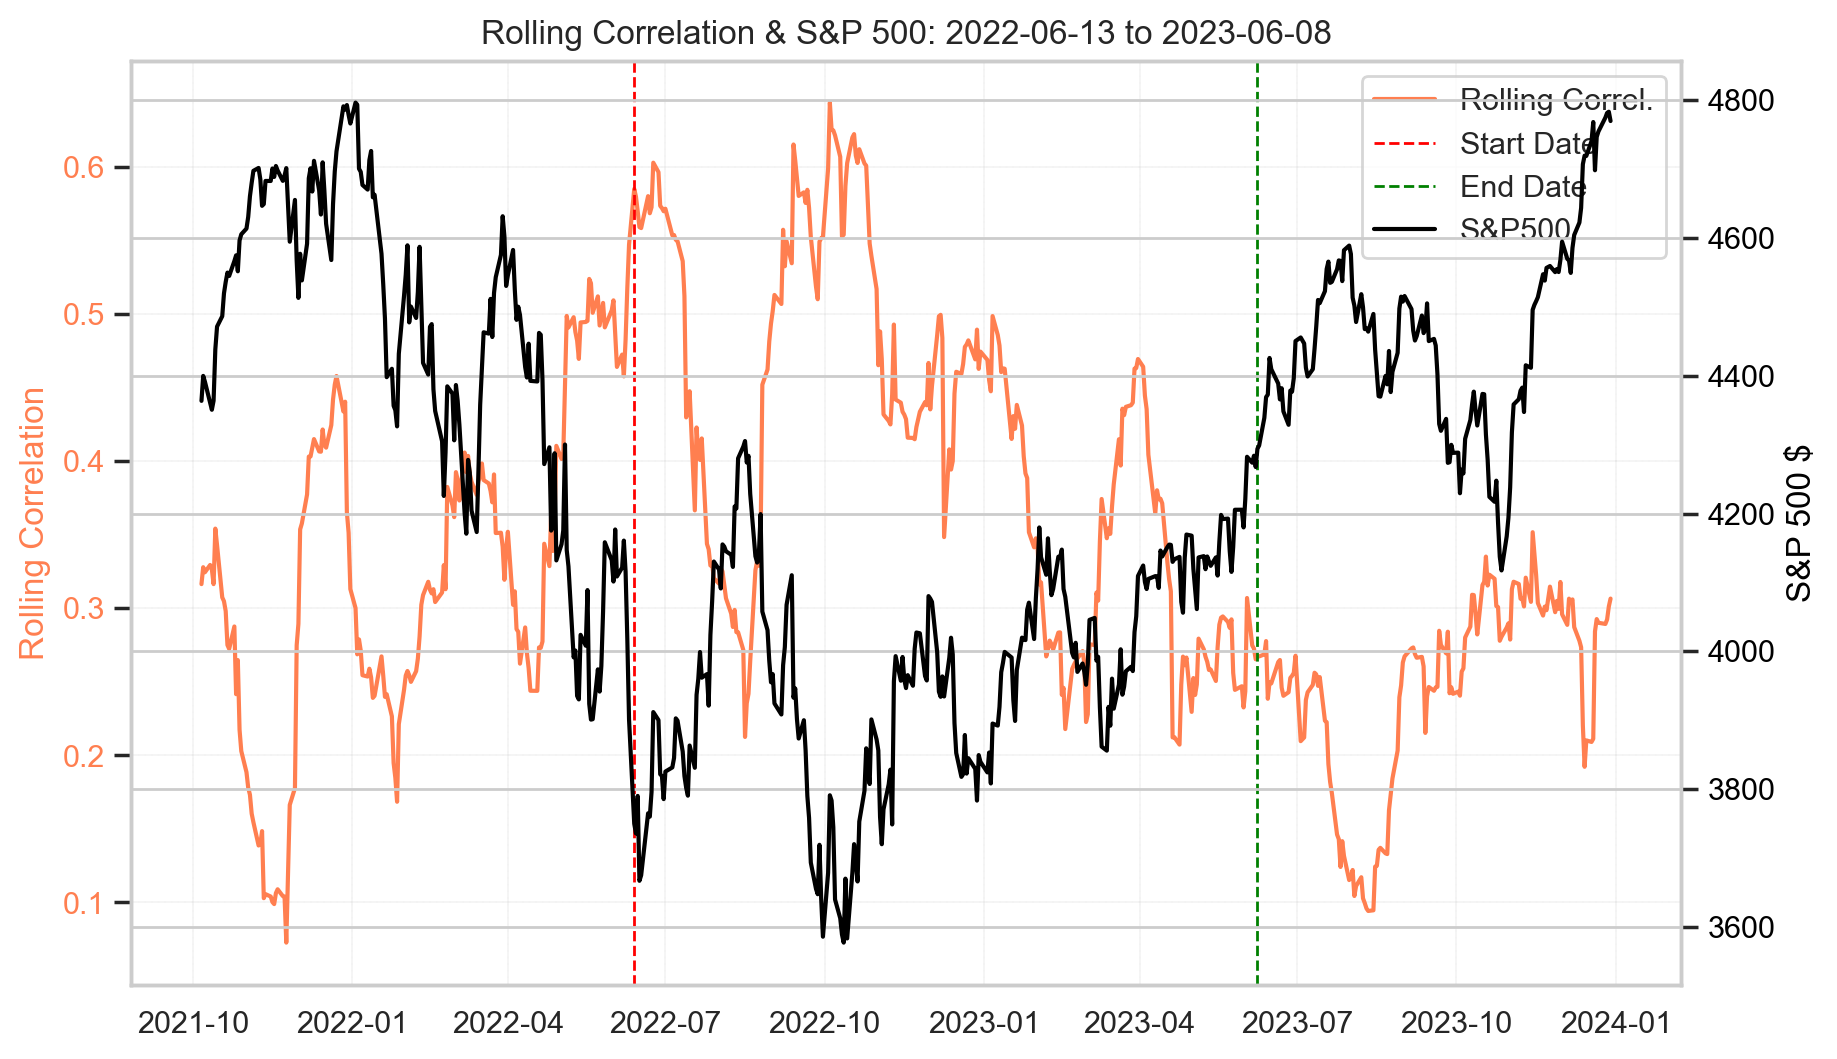

In [13]:
rolling20Correl = moving_correlations_df

for start_date, end_date in crisis_periods:
    adjusted_start_date = start_date - pd.Timedelta(days=250)
    adjusted_end_date = end_date + pd.Timedelta(days=250)
    
    fig, ax1 = plt.subplots(figsize=(10,6),dpi = 200)
    ax1.plot(rolling20Correl.loc[adjusted_start_date:adjusted_end_date], color='coral', label='Rolling Correl.', linewidth=1.5)
    
    ax1.axvline(x=start_date, color='red', linestyle='--', lw=1, label='Start Date', linewidth = 2.2)
    ax1.axvline(x=end_date, color='green', linestyle='--', lw=1, label='End Date', linewidth = 2.2)

    ax1.grid(True, which='major', linestyle='--', linewidth='0.08', color='grey')
    ax1.grid(True, which='minor', linestyle='--', linewidth='0.08', color='grey')
    
    ax2 = ax1.twinx()  
    ax2.plot(sp500['^GSPC'].loc[adjusted_start_date:adjusted_end_date], color='black', alpha=1, label='S&P500', linewidth=1.5)

    ax1.set_title(f"Rolling Correlation & S&P 500: {start_date.date()} to {end_date.date()}")
    ax1.set_ylabel('Rolling Correlation', color='coral')
    ax2.set_ylabel('S&P 500 $', color='black')
    ax1.tick_params(axis='y', labelcolor='coral')
    ax2.tick_params(axis='y', labelcolor='black')
    
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(handles1 + handles2, labels1 + labels2, loc='best')
    plt.show()

## Rolling correlations
1.	To minimize noise and carefully analyze the periods, each crisis is plotted individually with rolling correlation (for a smoother line) and S&P 500 returns. During a crisis, ideally an inverse relationship should be observed (an 'X' shaped plot), indicating a market sell-off leading to lower returns and higher correlation.

2.	We encourage the reader to observe the period slightly before the start of each crisis (to account for our definition of a crisis as a -20% return) until slightly after the end. Crisis start date is marked by a vertical dashed red line, whereas the crisis end date is marked by a green one. 


* Crisis of 1982 - Recession and high inflation
    + While an inverse relationship is somewhat visible, the limited dataset of only 196 stocks doesn't fully capture it.  

* Crisis of 1987 - Black Monday
    + With more comprehensive data, the trend of market-wide sell-offs becomes clearer, with correlations reaching just above 0.7. 
    + The exact cause is still debated, with algorithmic trading's snowball effect being a prevalent theory.
* Crisis of 2001 - Dot-com and terrorist attack
    + The bursting dot-com bubble and subsequent bankruptcies marked the start, followed by a sharp downturn after the September terrorist attacks in the USA, showing a clear inverse relationship between high correlation and negative returns.
* Crisis of 2002 - Dot-com
    + The continued drying up of capital for internet companies and increased bankruptcies left investors with significant losses, reflected in high correlations of negative sentiment.
* Crisis of 2008 - The great financial crisis (GFC)
    + The great financial crisis – Decline in home sales, foreclosures, toxic bank debts, Fannie Mae's and Freddie Mac's shares tumble trigger our crisis with negative-20% returns. 
    + With bankruptcy declaration of Bear Sterns on September 15, market panic shows very high correlation and very negative returns showcasing a good example of a cross pattern.
* Crisis of 2009 - Continuation of the GFC
    + Due to our definition of a crisis we get another crisis in 2009 but for a period of just a month.
    + Government announced stimulus package leading to +20% return from the lowest point but the problem was deep. Government had to announce a lot of “bailouts” leading to worse outlooks for the economy.

* Crisis of 2020 - Global pandemic
    + WHO recommended the outbreak of Covid-19 virus with quarantine measures. Leading the market to forecast reduced demands globally and a sell-off. 
    + Global reduced demand leads to a higher correlation across the industries mitigated by stimulus package announcement by the fed.

* Crisis of 2022 - Interest rate hikes
    + We consider this a unique scenario, as the crisis extended over a year. Therefore, it does not provide strong evidence to establish the relationship between correlations and crisis periods.

{{< pagebreak >}}

# Beta Analysis

## Monthly and Quarterly Mean Beta analysis with summary statistics

* The quarterly and monthly mean beta graphs were plotted to visually examine the data and identify any potential patterns. 

* Further investigation is needed to understand the reasons behind extreme beta spikes, such as those observed in 1994 and 2007.

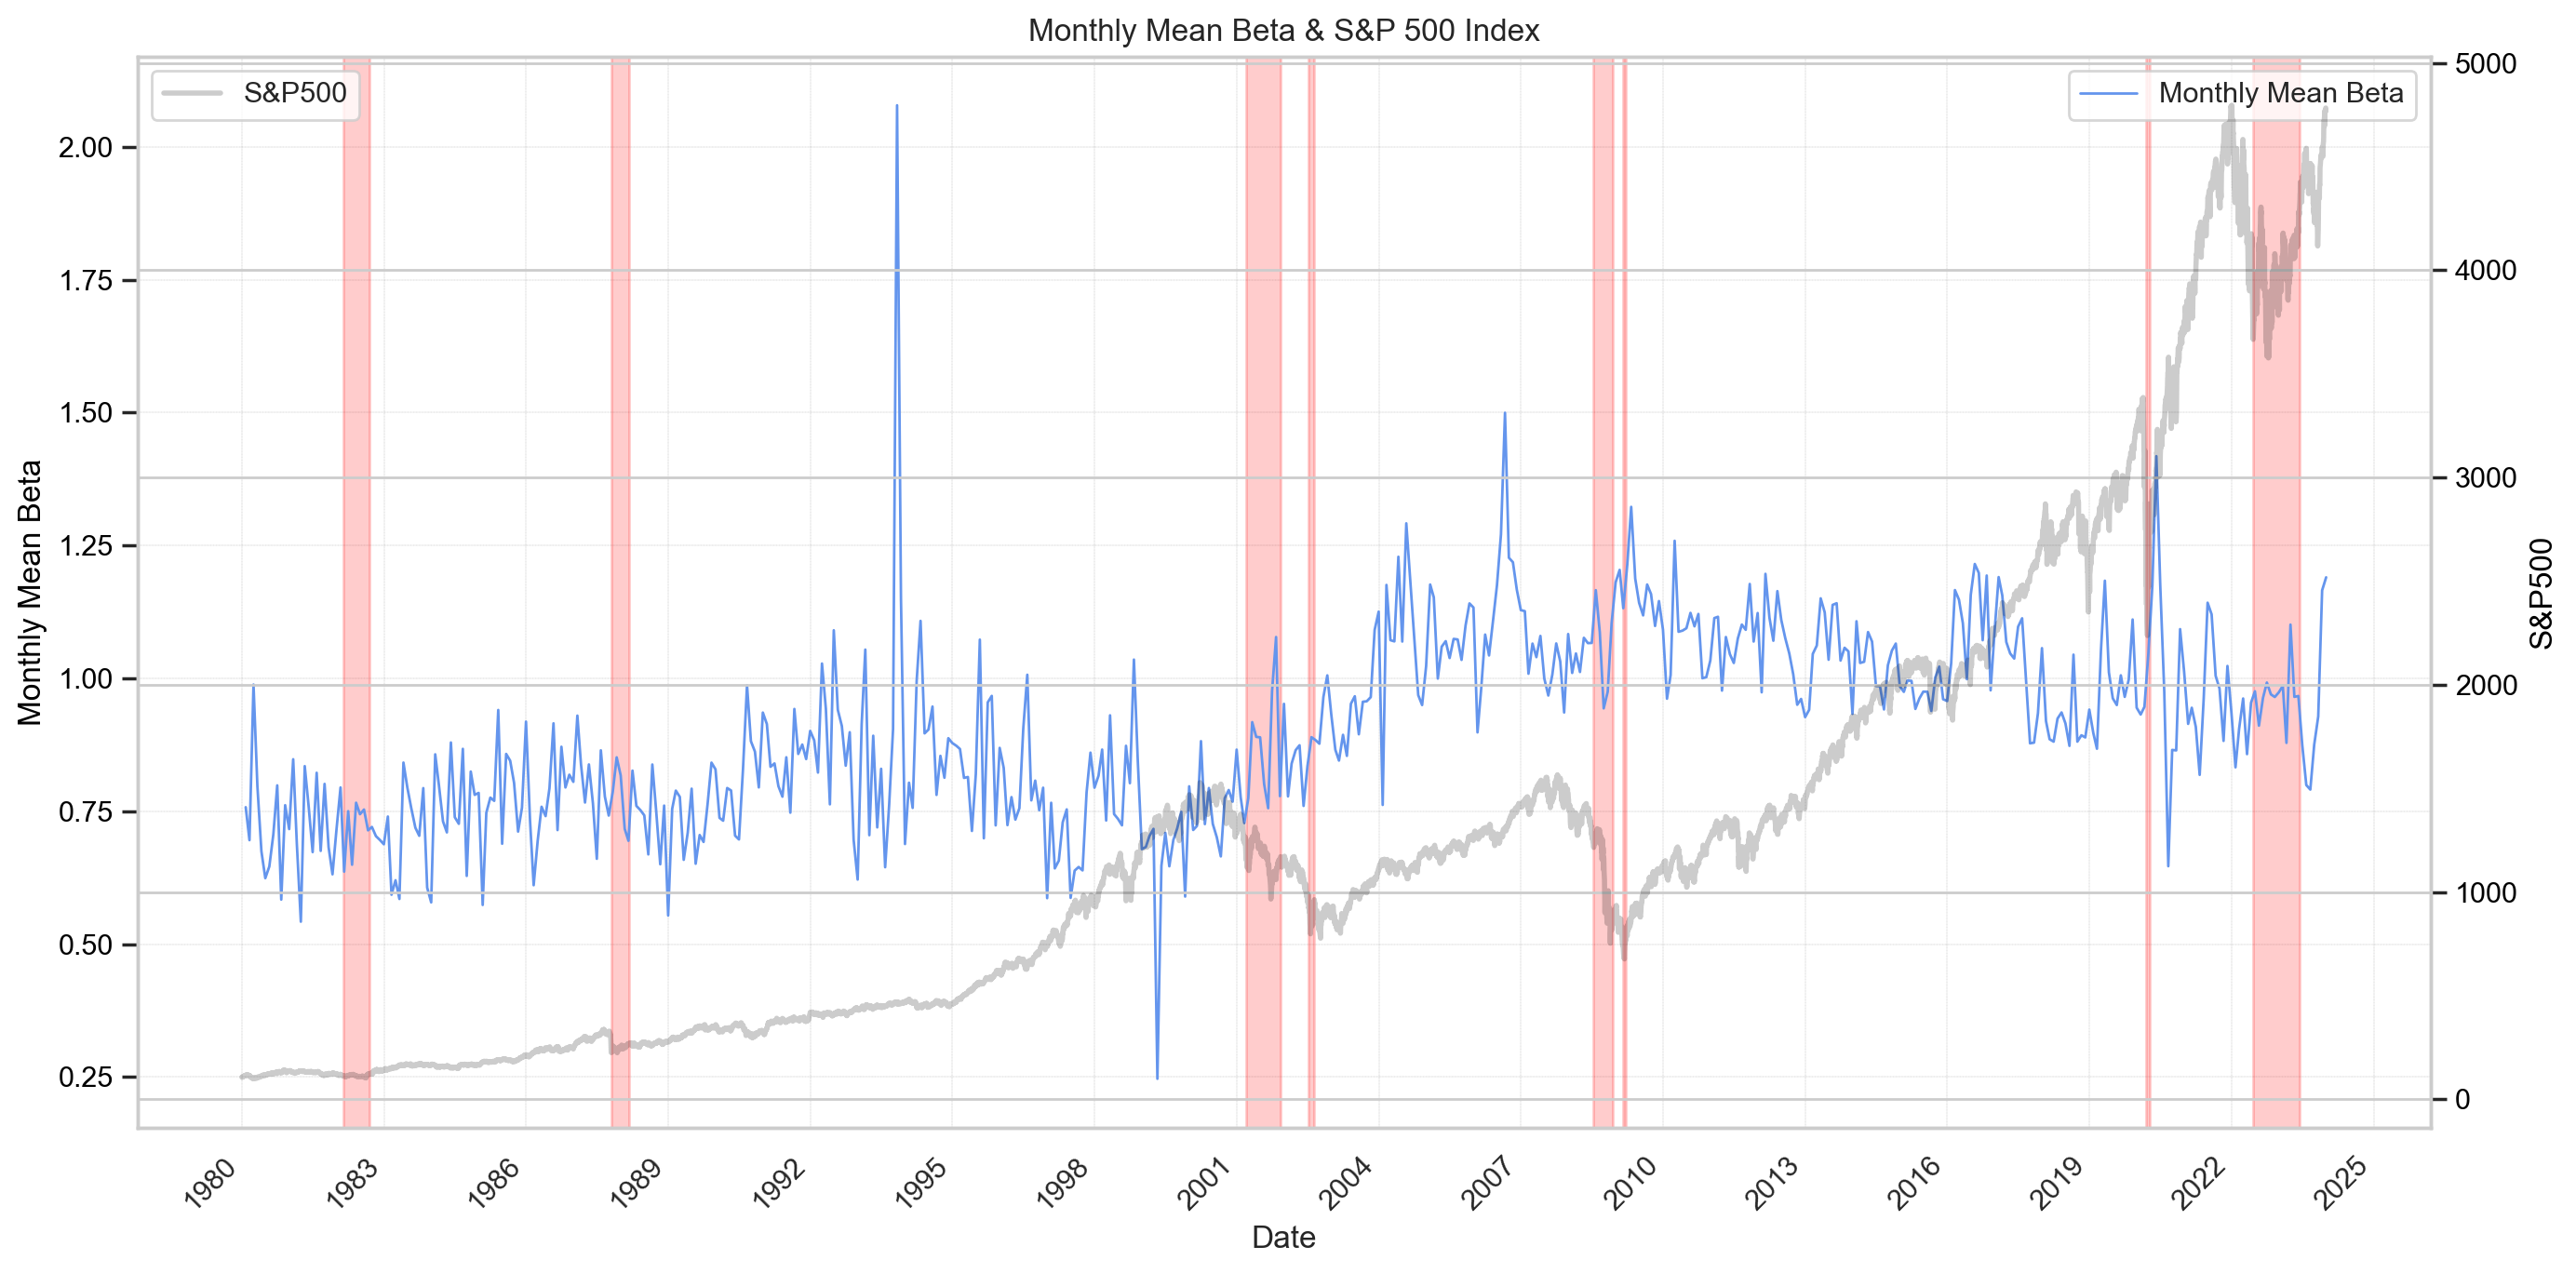

In [14]:
#MONTHLY MEAN
monthly_var_sp500 = sp500['sp500_dr'].resample('M').var()
monthly_cov_with_sp500 = sp500.iloc[:,:-2].resample('M').apply(lambda x: x.cov(sp500['sp500_dr']))
monthly_beta_mean = monthly_cov_with_sp500.div(monthly_var_sp500, axis=0).mean(axis=1)

fig, ax1 = plt.subplots(figsize=(14, 7), dpi = 200)

ax1.set_xlabel('Date')
ax1.set_ylabel('Monthly Mean Beta', color='black')
ax1.plot(monthly_beta_mean.index, monthly_beta_mean, color='cornflowerblue', linewidth=1, label = 'Monthly Mean Beta')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, which='major', linestyle='--', linewidth='0.1', color='grey')
ax1.grid(True, which='minor', linestyle=':', linewidth='0.1', color='grey')

for start, end in crisis_periods:
    ax1.axvspan(start, end, color='red', alpha=0.2)

ax2 = ax1.twinx()  
ax2.set_ylabel('S&P500', color='black')  
ax2.plot(sp500['^GSPC'].index, sp500['^GSPC'], color='black', linewidth = 2, alpha = 0.2, label = 'S&P500')
ax2.tick_params(axis='y', labelcolor='black')

ax1.xaxis.set_major_locator(mdates.YearLocator(3))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

ax2.legend(loc='upper left')
ax1.legend(loc='upper right')

plt.title("Monthly Mean Beta & S&P 500 Index")
plt.tight_layout()
plt.show()

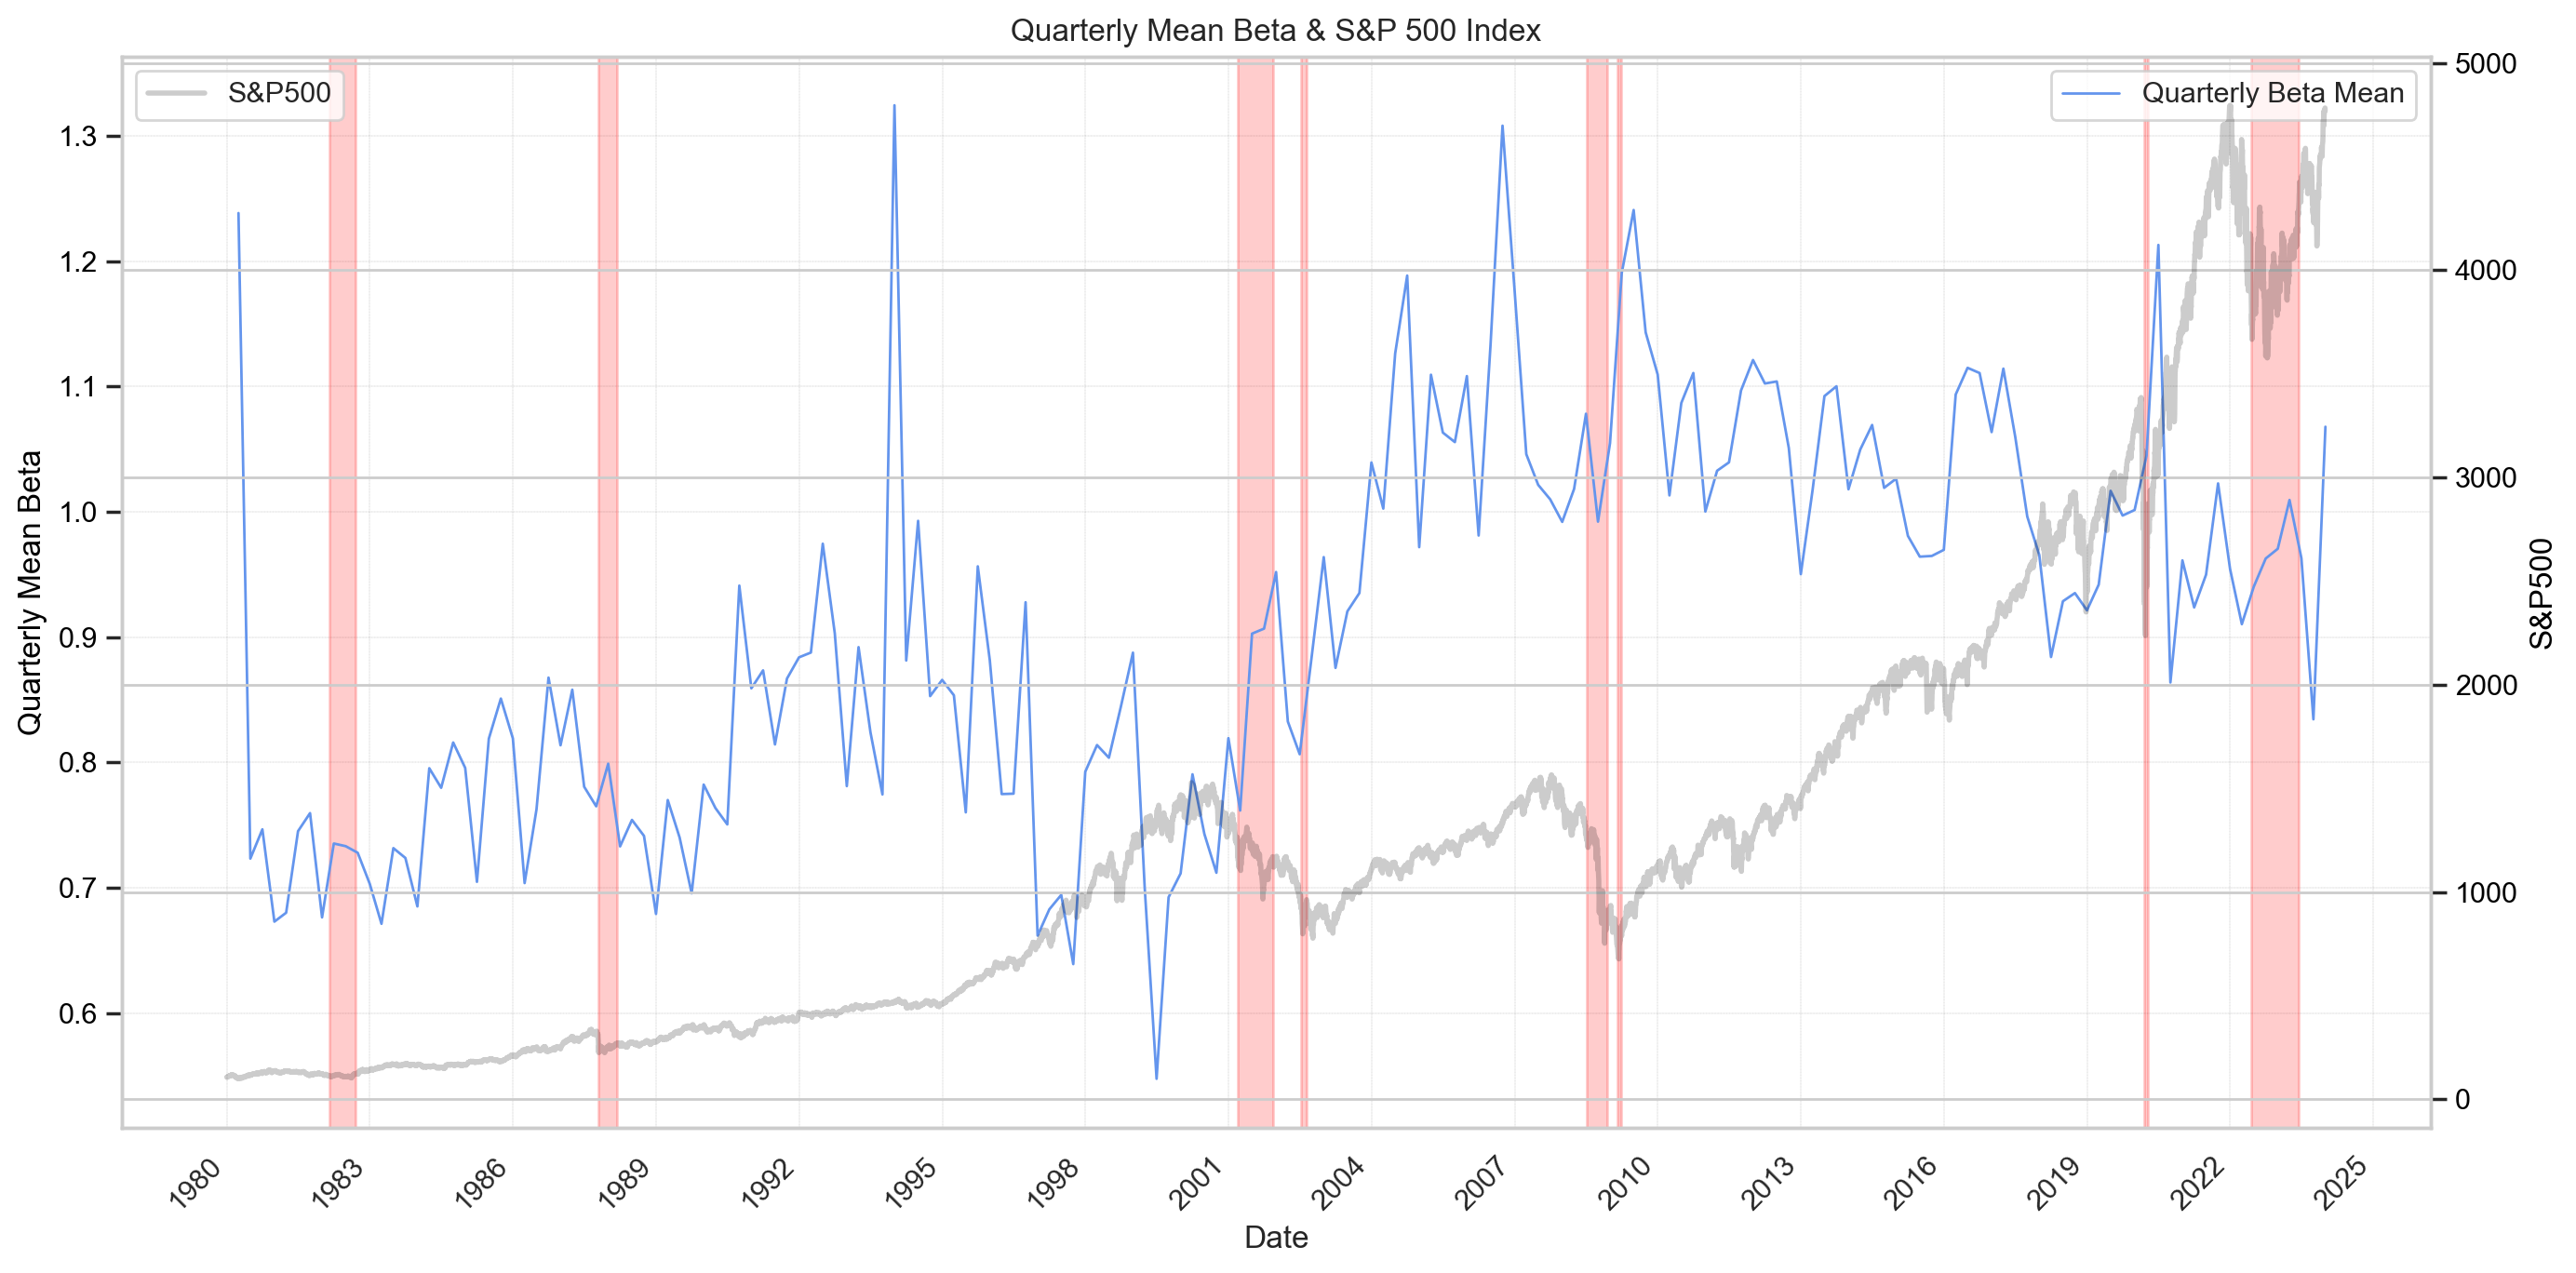

In [15]:
#QUARTERLY MEAN
quarterly_var_sp500 = sp500['sp500_dr'].resample('Q').var()
quarterly_cov_with_sp500 = sp500.iloc[:,:-2].resample('Q').apply(lambda x: x.cov(sp500['sp500_dr']))
quarterly_beta_mean = quarterly_cov_with_sp500.div(quarterly_var_sp500, axis=0).mean(axis=1)

fig, ax1 = plt.subplots(figsize=(14, 7), dpi = 200)

ax1.set_xlabel('Date')
ax1.set_ylabel('Quarterly Mean Beta', color='black')
ax1.plot(quarterly_beta_mean.index, quarterly_beta_mean, color='cornflowerblue', linewidth=1, label = 'Quarterly Beta Mean')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, which='major', linestyle='--', linewidth='0.1', color='grey')
ax1.grid(True, which='minor', linestyle=':', linewidth='0.1', color='grey')

for start, end in crisis_periods:
    ax1.axvspan(start, end, color='red', alpha=0.2)

ax2 = ax1.twinx()  
ax2.set_ylabel('S&P500', color='black')  
ax2.plot(sp500['^GSPC'].index, sp500['^GSPC'], color='black', linewidth = 2, alpha = 0.2, label = 'S&P500')
ax2.tick_params(axis='y', labelcolor='black')

ax1.xaxis.set_major_locator(mdates.YearLocator(3))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

ax2.legend(loc='upper left')
ax1.legend(loc='upper right')

plt.title("Quarterly Mean Beta & S&P 500 Index")
plt.tight_layout()
plt.show()

## Monthly and Quarterly Median Beta analysis

The graphs illustrate the relationship between the median betas of all stocks. The median values of stock betas mitigate the impact of extreme values in either direction, effectively portraying how a typical stock's beta responds during a crisis. We observe similar spikes in the median beta within the red-shaded crisis periods, with the beta trending towards 1.

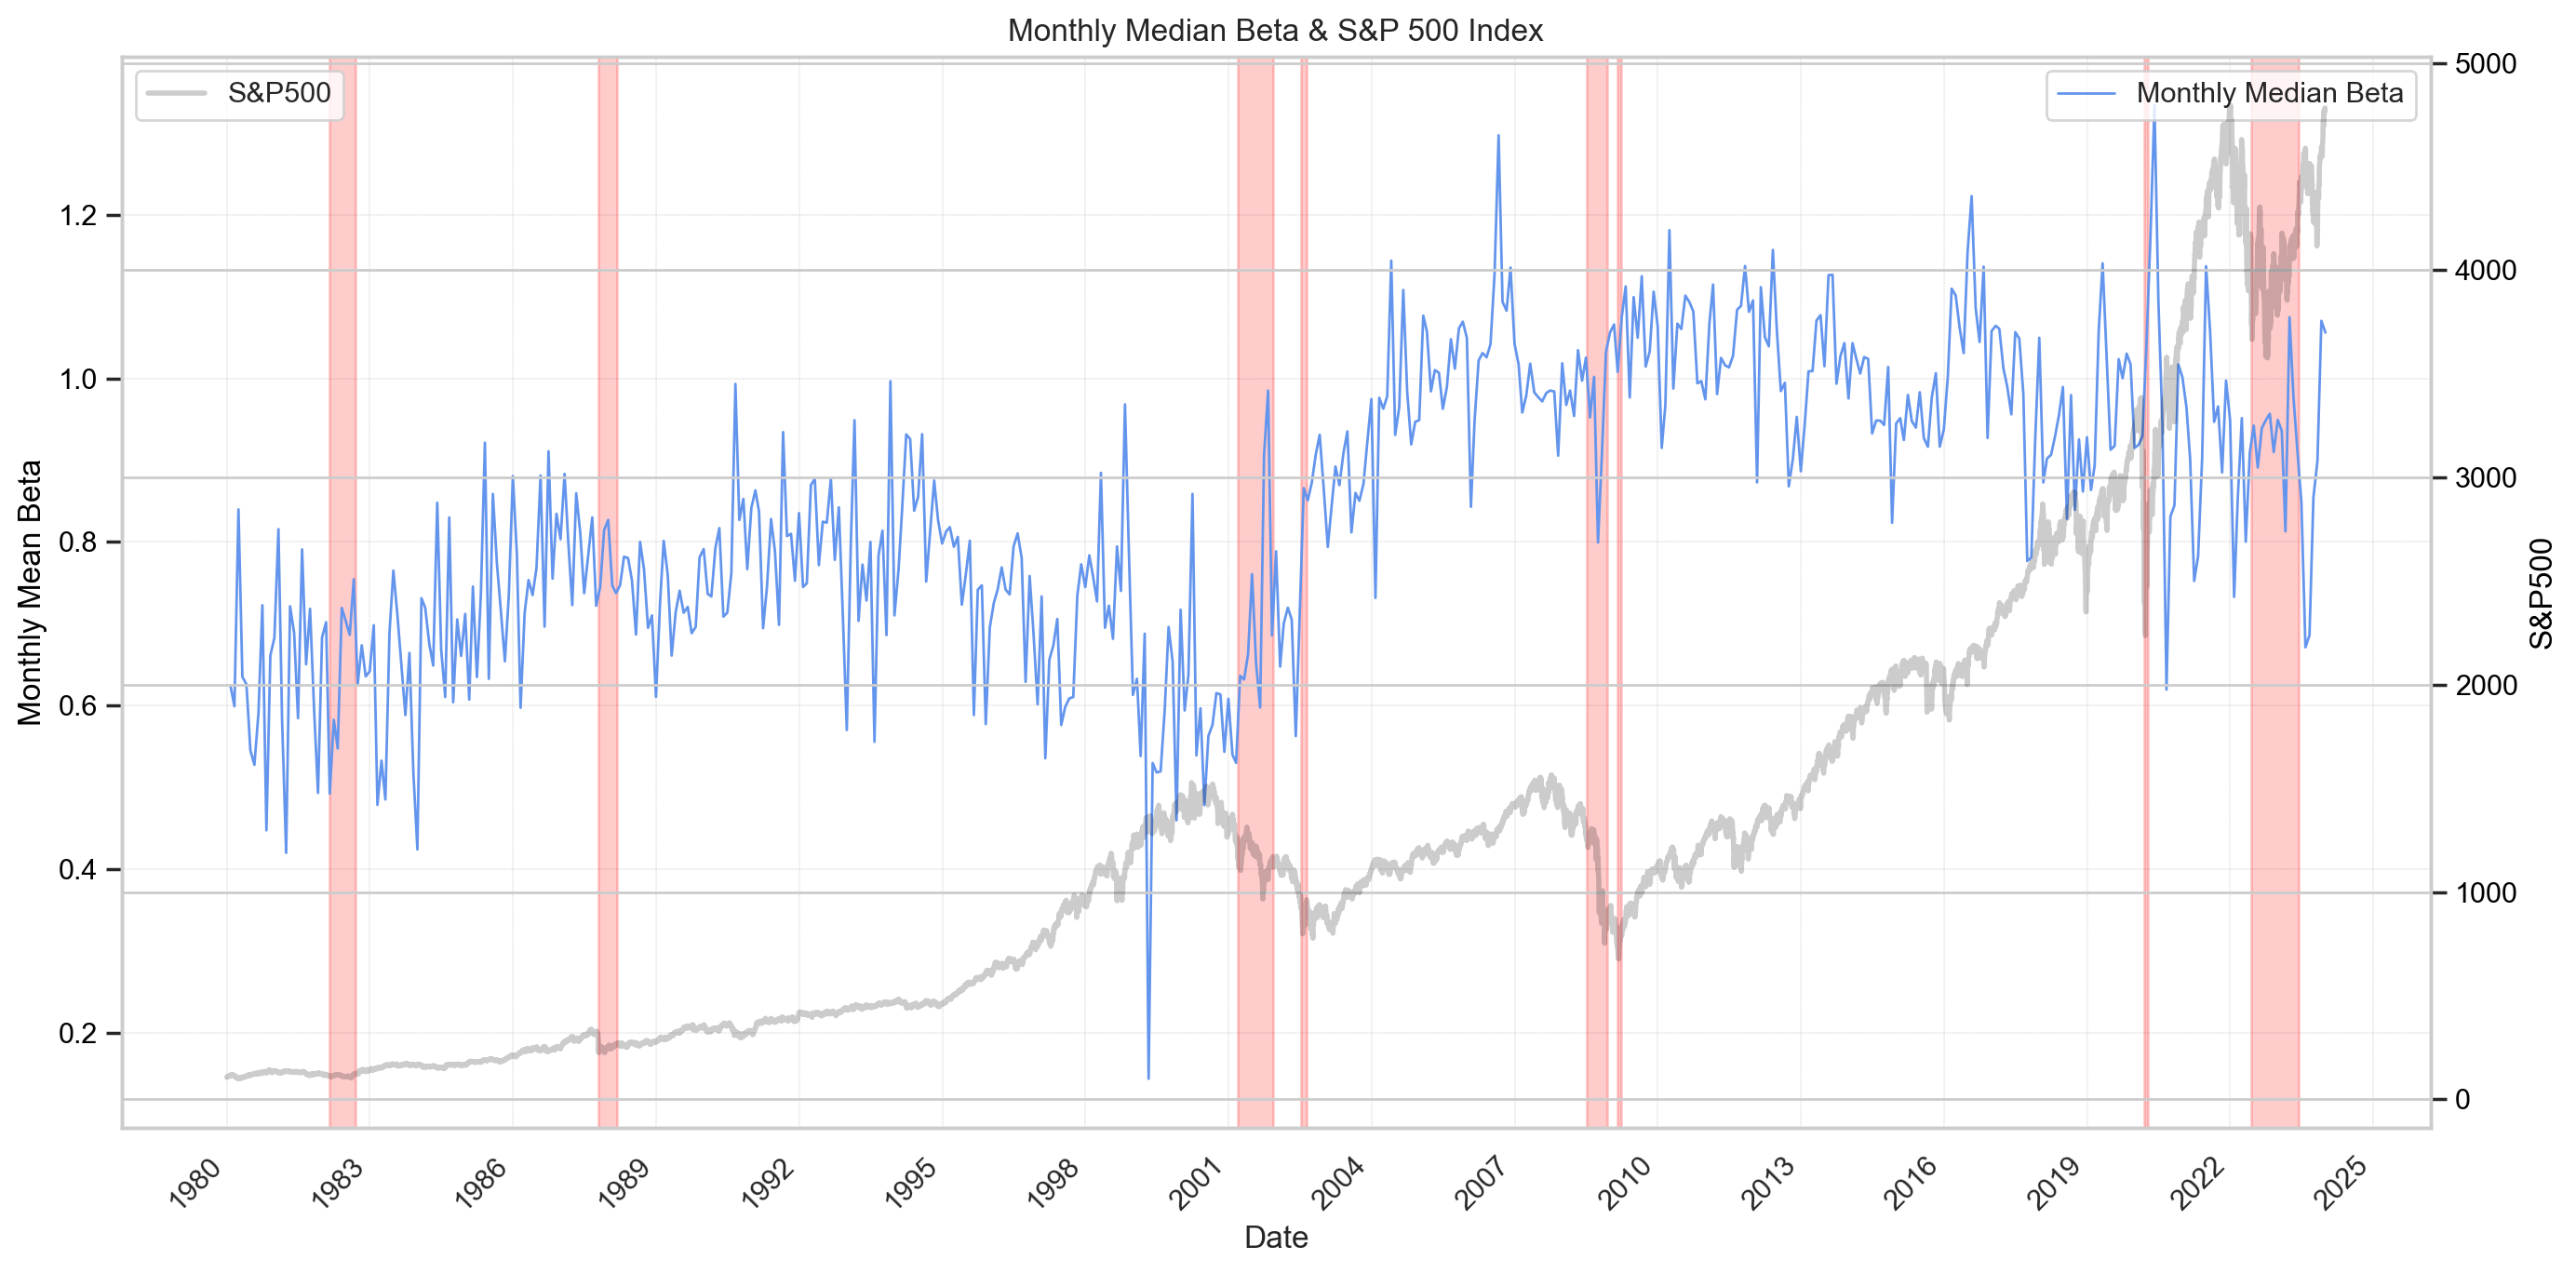

In [16]:
#MONTHLY MEDIAN
monthly_var_sp500 = sp500['sp500_dr'].resample('M').var()
monthly_cov_with_sp500 = sp500.iloc[:,:-2].resample('M').apply(lambda x: x.cov(sp500['sp500_dr']))
monthly_beta_median = monthly_cov_with_sp500.div(monthly_var_sp500, axis=0).median(axis=1)

fig, ax1 = plt.subplots(figsize=(14, 7), dpi = 200)

# color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Monthly Mean Beta', color='black')
ax1.plot(monthly_beta_median.index, monthly_beta_median, color='cornflowerblue', linewidth=1, label = 'Monthly Median Beta')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, which='major', linestyle='--', linewidth='0.1', color='grey')
ax1.grid(True, which='minor', linestyle=':', linewidth='0.1', color='grey')

for start, end in crisis_periods:
    ax1.axvspan(start, end, color='red', alpha=0.2)

ax2 = ax1.twinx()  
ax2.set_ylabel('S&P500', color='black')  
ax2.plot(sp500['^GSPC'].index, sp500['^GSPC'], color='black', linewidth = 2, alpha = 0.2, label = 'S&P500')
ax2.tick_params(axis='y', labelcolor='black')

ax1.xaxis.set_major_locator(mdates.YearLocator(3))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

ax2.legend(loc='upper left')
ax1.legend(loc='upper right')

plt.title("Monthly Median Beta & S&P 500 Index")
plt.tight_layout()
plt.show()

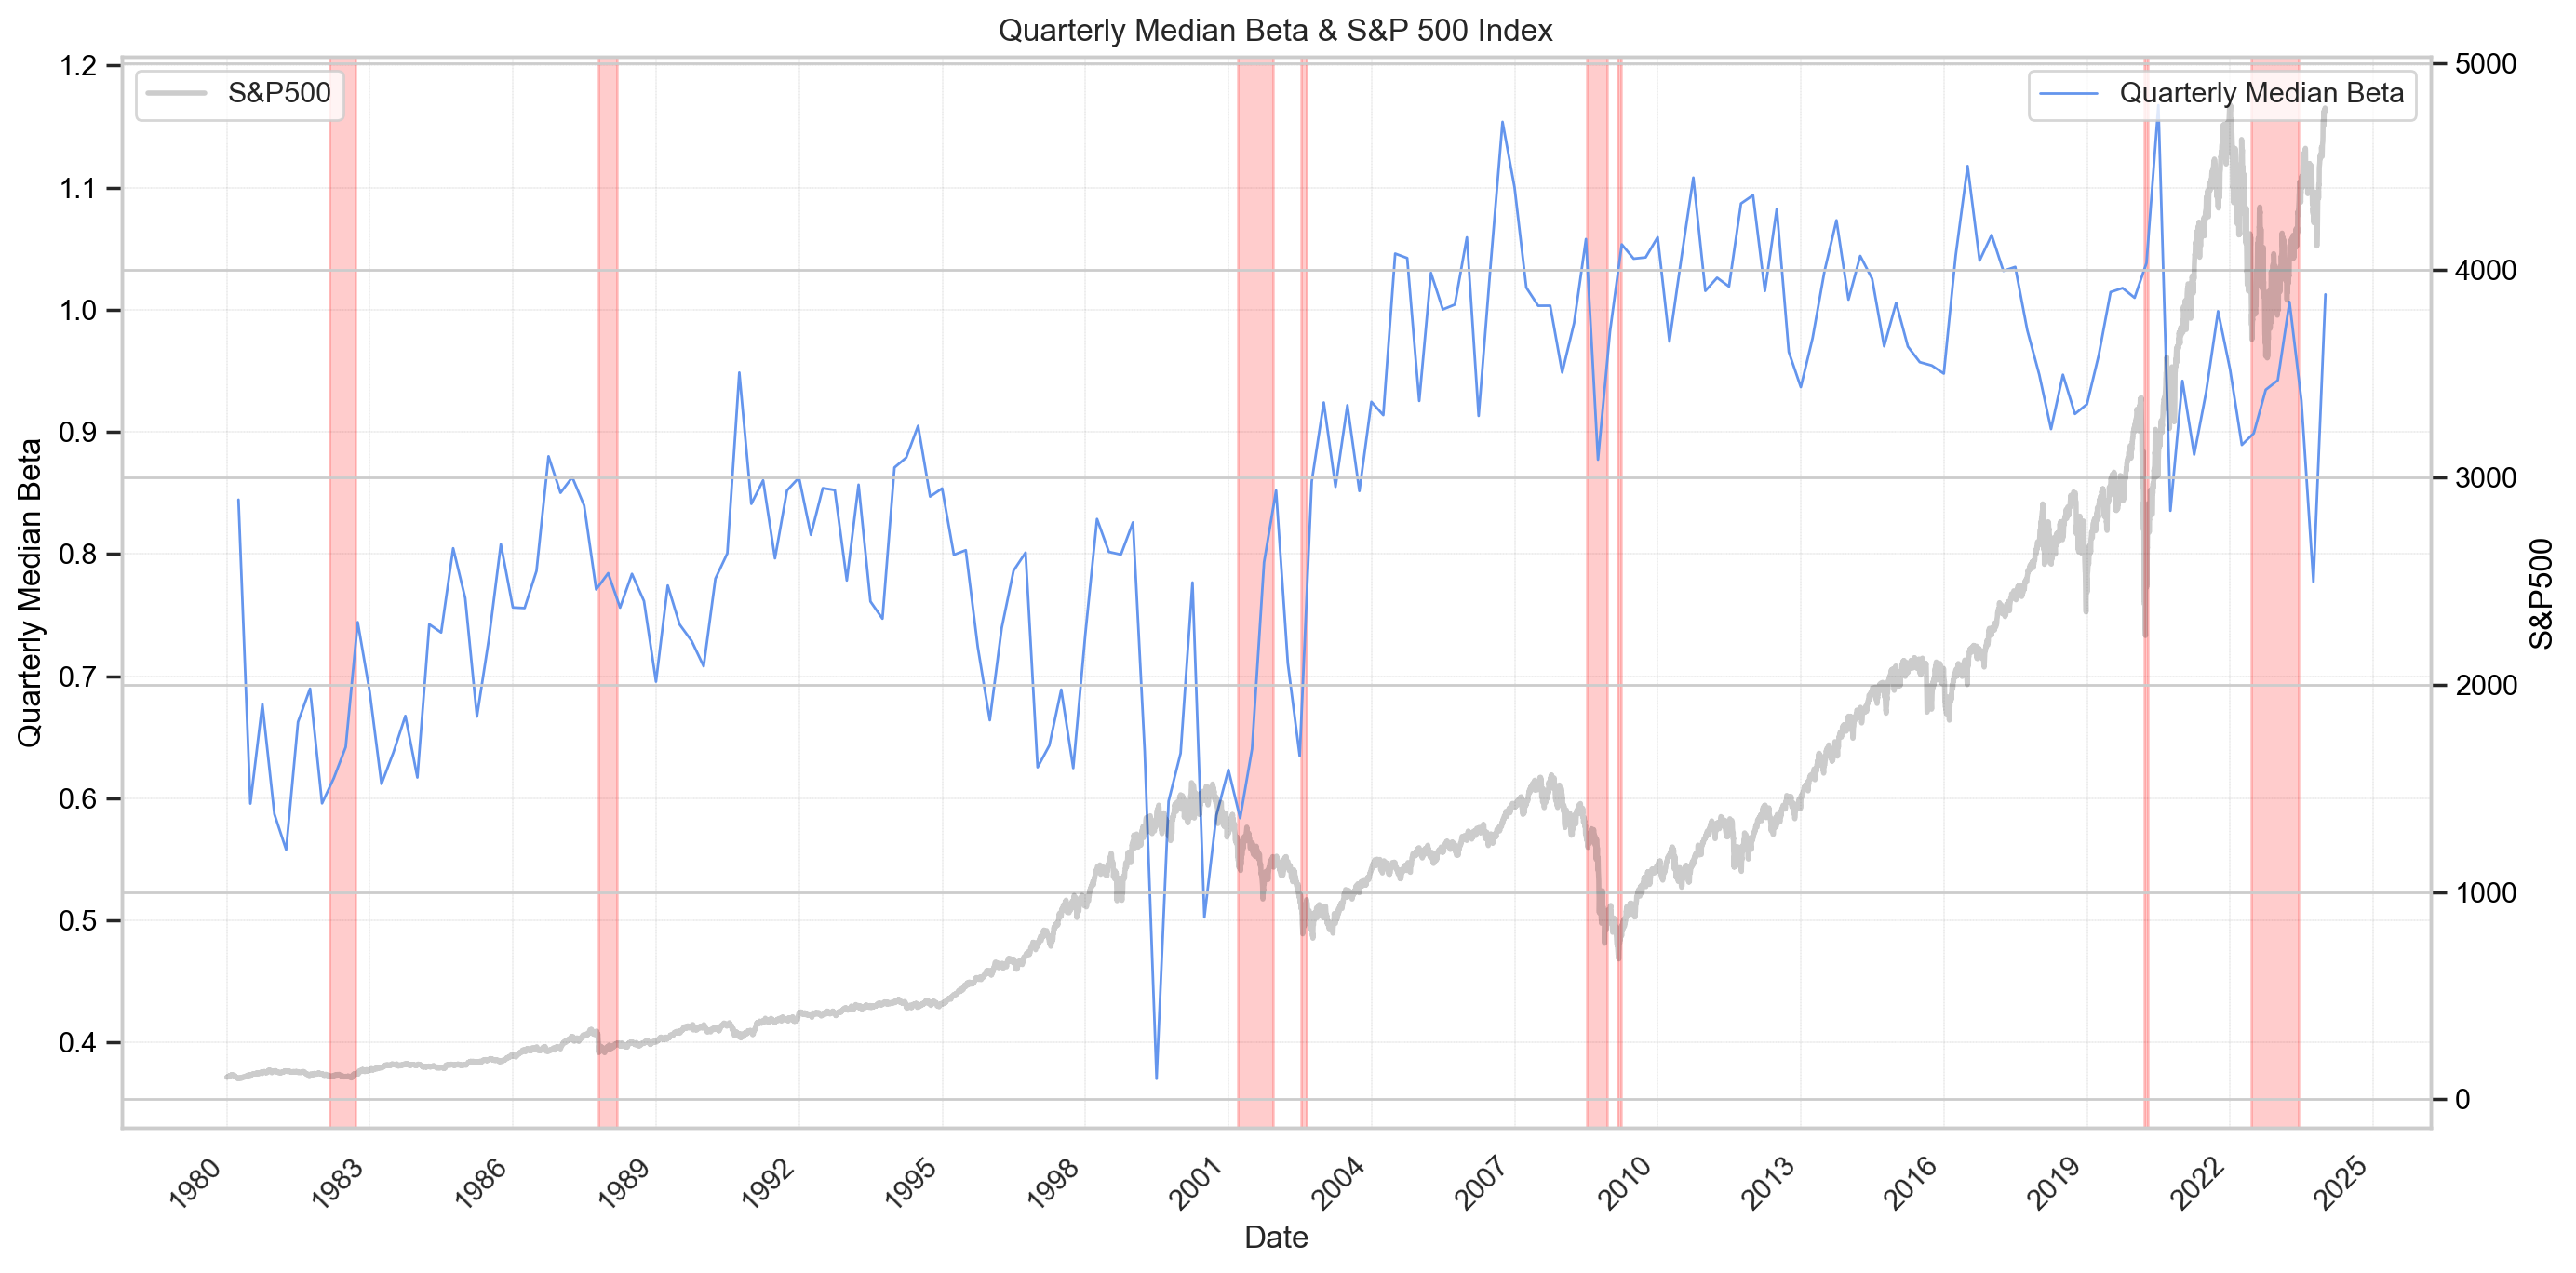

In [17]:
#QUARTERLY MEDIAN
quarterly_var_sp500 = sp500['sp500_dr'].resample('Q').var()
quarterly_cov_with_sp500 = sp500.iloc[:,:-2].resample('Q').apply(lambda x: x.cov(sp500['sp500_dr']))
quarterly_beta_median = quarterly_cov_with_sp500.div(quarterly_var_sp500, axis=0).median(axis=1)

fig, ax1 = plt.subplots(figsize=(14, 7), dpi = 200)

ax1.set_xlabel('Date')
ax1.set_ylabel('Quarterly Median Beta', color='black')
ax1.plot(quarterly_beta_median.index, quarterly_beta_median, color='cornflowerblue', linewidth=1, label = 'Quarterly Median Beta')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, which='major', linestyle='--', linewidth='0.1', color='grey')
ax1.grid(True, which='minor', linestyle=':', linewidth='0.1', color='grey')

for start, end in crisis_periods:
    ax1.axvspan(start, end, color='red', alpha=0.2)

ax2 = ax1.twinx()  
ax2.set_ylabel('S&P500', color='black')  
ax2.plot(sp500['^GSPC'].index, sp500['^GSPC'], color='black', linewidth = 2, alpha = 0.2, label = 'S&P500')
ax2.tick_params(axis='y', labelcolor='black')

ax1.xaxis.set_major_locator(mdates.YearLocator(3))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

ax2.legend(loc='upper left')
ax1.legend(loc='upper right')

plt.title("Quarterly Median Beta & S&P 500 Index")
plt.tight_layout()
plt.show()



{{< pagebreak >}}

## Distribution of Beta values

In [18]:
results = []

for start_date, end_date in crisis_periods:

    beta_values = sp500.iloc[:, :-2].loc[start_date:end_date].apply(
        lambda x: x.cov(sp500['sp500_dr'].loc[start_date:end_date]) / sp500['sp500_dr'].loc[start_date:end_date].var()
    ).dropna()
    
    betas_in_range = beta_values[(beta_values >= 0.8) & (beta_values <= 1.2)]
    
    percent_in_range = len(betas_in_range) / len(beta_values) * 100
    beta_mean = beta_values.mean()
    
    results.append({
        "Start Date": start_date,
        "End Date": end_date,
        "% in range 0.8 - 1.2": percent_in_range,
        "Total Stocks Analyzed": len(beta_values),
        "Mean Beta": beta_mean,
    })

results_df = pd.DataFrame(results)

results_df

Start Date   End Date  % in range 0.8 - 1.2  Total Stocks Analyzed  \
0 1982-02-22 1982-09-14             29.381443                    194   
1 1987-10-19 1988-03-08             33.613445                    238   
2 2001-03-12 2001-12-05             24.409449                    381   
3 2002-07-10 2002-08-22             41.818182                    385   
4 2008-07-09 2008-12-08             42.626728                    434   
5 2009-02-23 2009-03-23             32.718894                    434   
6 2020-03-12 2020-04-08             52.208835                    498   
7 2022-06-13 2023-06-08             46.015936                    502   

   Mean Beta  
0   0.730458  
1   0.787293  
2   0.894514  
3   0.872492  
4   1.030343  
5   1.192679  
6   1.066041  
7   0.976019

1. Analyzing the proportion of stocks within a specific range provides insights into the accuracy of the analysis.

2. At most, only around 50% of stocks fall between the beta range of 0.8 to 1.2.

3. Before 2001, only 38-48% of the current S&P 500 stocks were present, as many stocks were not part of the index back then. This results in a less reliable dataset for beta calculation, decreasing accuracy.

4. As the number of data points increases, the analysis suggests that the average Beta tends towards 1 during crisis periods.

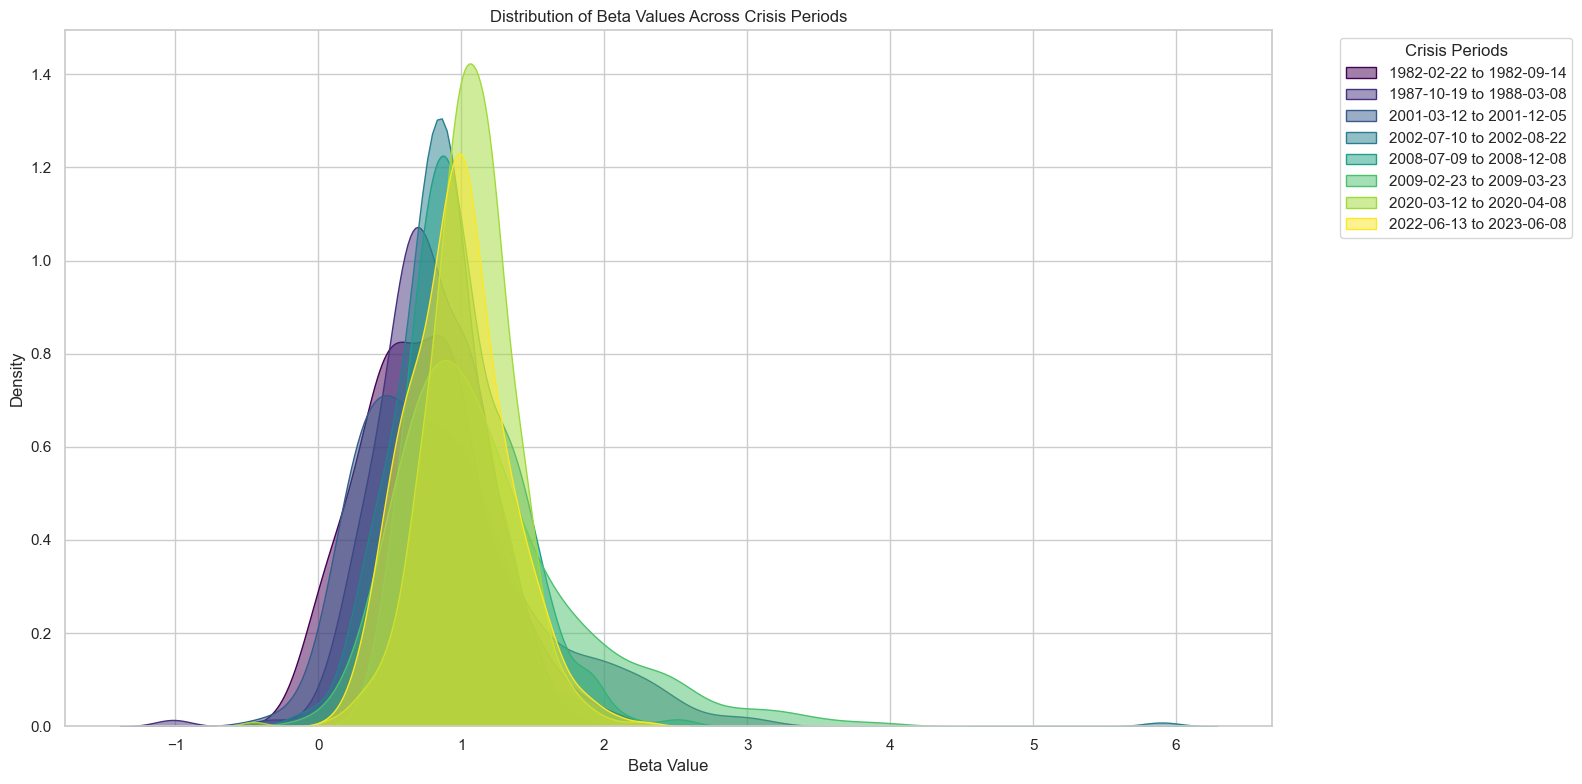

In [19]:
plt.figure(figsize=(16, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(crisis_periods)))

for i, (start_date, end_date) in enumerate(crisis_periods):
    
    beta_values = sp500.iloc[:, :-2].loc[start_date:end_date].apply(
        lambda x: x.cov(sp500['sp500_dr'].loc[start_date:end_date]) / sp500['sp500_dr'].loc[start_date:end_date].var()
    ).dropna()
    
    
    sns.kdeplot(beta_values, fill=True, alpha=0.5, color=colors[i], label=f'{start_date.date()} to {end_date.date()}')

title = "Distribution of Beta Values Across Crisis Periods"
xlabel = "Beta Value"

plt.title(title)
plt.xlabel(xlabel)
plt.ylabel('Density')
plt.legend(title='Crisis Periods', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

- The distribution graph shows peaks more centered around 1, indicating a sensitivity similar to the overall market. Additionally, we observe lower skewness in recent crisis periods, with less pronounced tails, further evidencing stronger market sensitivity.

{{< pagebreak >}}

# Weaknesses in our analysis

* Incomplete data:
    + We analyze the market in terms of the S&P 500, which should comprise 500 stocks. However, only 196 companies were identified in our 1982 crisis analysis, and roughly half in 1987.
    + The missing data might have helped us better explain the correlations.
    + As many of the companies were not part of the S&P 500 from their listing date, our analysis may not fully capture their performance relative to the S&P 500.

* Equal-weighted index:
    + We assume the S&P 500 to be equally weighted for all stocks it contains.
    + In reality, the S&P 500 is a market capitalization-weighted index.
    + Not accounting for this critical distinction may have skewed the numbers in our analysis.

* Covariance: 
    + Covariance measures how two stocks move together. During a crisis, if stocks react similarly by moving in the same direction, their covariance can increase. 
    + However, certain sectors or stocks may be less impacted or even benefit from specific crises, like healthcare or tech stocks during relevant crises. In these cases, the covariance between these and more affected stocks might decrease or behave unpredictably.
    + Although we incorporated covariance in our analysis, the project scope focused more on correlation and Beta.
    + When covariance between a stock and the market increases, it means that individual stock returns are more connected to overall market movements, showing the crisis's impact on them.

A possible solution to the data problem is having a dynamic dataset that accurately reflects the stocks listed in the S&P 500 at any given time. This would greatly improve the precision of our analysis.
 


# Conclusion

- Correlations during crises have been observed to be higher than the non-crisis periods.

- Shortcomings in terms of lack of data and discrepancies between actual index calculation and our calculations have thrown off the values calculated.

- Negative bias confirms that the correlation would rise in bearish times, but in bullish runs, people tend to be conservative about entering the market.

- This reflects the market's overall risk aversion and lack of differentiation.
